## Optimal intraday wind trading : balancing forecast error in intraday market with dynamic programming approach

#### The objective of this approach is to make a study on how optimal trading policy may change accordingly to price and forecast volatility, transaction cost and liquidity on intraday market. The model is tested under different market scenario.

#### [Reference]
Garnier and Madlener 2014 : https://www.fcn.eonerc.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaaaiupue

### Objective

- Optimization and hedging position along all trading windows
- This try to Address the following problems:
    - At which moment it is better to trade
    - Is there any value of waiting to trade
    - At each time to delivery shall we close the position
    - how can we adjust the trading policy with daily market conditions 
- Use of discrete stochastic control problem formuation
- Implementation with option valuation lattice based model from ref Garnier and Madlener 2014



In [1]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
#import tensorflow as tf

### Problem formulation

The purpose of this model is to optimize the balancing wind forecast error in continuous-trade intraday wind power market (Germany market in this study).
- We assume an uncertainty in both intraday prices and wind forecast production
- We assume a continuous-trade approach, this means that we can trade from let's say 10h to 45min before delivery time in our case.

Let's consider an hourly product with delivery time T in the intraday market.
The intraday trading period preceding delivery T is dissected into trade windows      
Ⱳ = {1, … , W}, the end of W correspond to T-45min. In the following, t is the time begining of a trading window w in Ⱳ

We assume that a forecast-based quantity $X_{da}$ has been sold in the day-ahead market for the delivery T. 
The operator must attempt to provide exactly the amount previously sold without making use of the
imbalance market. This implies that any forecast error must be compensated by the end of the intraday trading at window W.

For practical purpose, we can define our trading windows such that at any begining time t, a new wind production  forecast $X_t$ is available, so that the operator will have to balance the derive estimated forecast error $F_t = (X_{da} - X_t)$ in the intraday market. (Remark : $𝐹_𝑊$ provides the actual
forecast error between day-ahead sale and actual delivery)

The goal is thus to find an optimal trade execution for an hourly product within the given trading windows

### Production Forecast and Intraday prices modelling

Intraday prices P are simulated by the classical GBM formula and its corresponding discrete time increments (between two trading windows for our purpose):

$$dP_t=\mu_p P_tdt+\sigma_p P_tdW^P_t\quad\quad P_{t+1}=P_te^{\left(\mu_p-\frac{1}{2}\sigma_p^2\right)\Delta t+\sigma_p\sqrt{\Delta t}Z^P}$$

where $Z^P$ is a standard normal random variable. 

Note that with this log-price model, negative and zero intraday prices are not allowed

Forecast errors are simulated using an ABM process. Here T is the lenght of trading window with T : delivery time

$$dF_t=\mu_F dt+\sigma_F dW^F_t\quad\quad F_{t+1}= F_{t} +\mu_F\Delta t+\sigma_F\sqrt{\Delta t}Z^F$$

where $Z^F$ is a standard normal random variable. Here, we can assume the following : $$\mu_F = 0$$

A difficulty of the modelling is that we have also a significant correlation between Intraday prices and forecast error, this means : $$d \langle W^P, W^F\rangle_t = \rho_{FP}dt\quad \rho_{FP} \neq 0$$

When simulating Monte Carlo pathes, if we want to work with decorrelated process, we can define an other process $\hat{W}^F_t$ such that : 
$dW^F_t = \rho_{FP}dW^P_t + \sqrt{1-\rho_{FP}^2}d\hat{W}^F_t$

with $\hat{W}^F_t$ and $W^P_t$ independant processes.

We can now rewritte our system as follow:
$$dP_t=\mu_p P_tdt+\sigma_p P_tdW^P_t$$

$$dF_t=\mu_F dt+\sigma_F(\rho_{FP}dW^P_t + \sqrt{1-\rho_{FP}^2}d\hat{W}^F_t)$$


For the dynamic programming, we will use a Tree based model optimization proceedure which is explained in Ernesto Garnier and Reinhard Madlener 2014 :
https://www.fcn.eonerc.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaaaiupue 
This approach is a modified version of the classical tree based dynamic programming approach for option pricing.

Note and discussion about the model: 

- An alternative model for intraday price is the Bachelier model : $dP_t=P_0+\sigma_p dW^P_t$ or mean reverting model or OU process which are also used in the litterature. 
- An important fact for forecasting dynamic calibration in our case is that we consider highly correlated sites (not geographically dispersed). The more generall problem needs some more calculation 



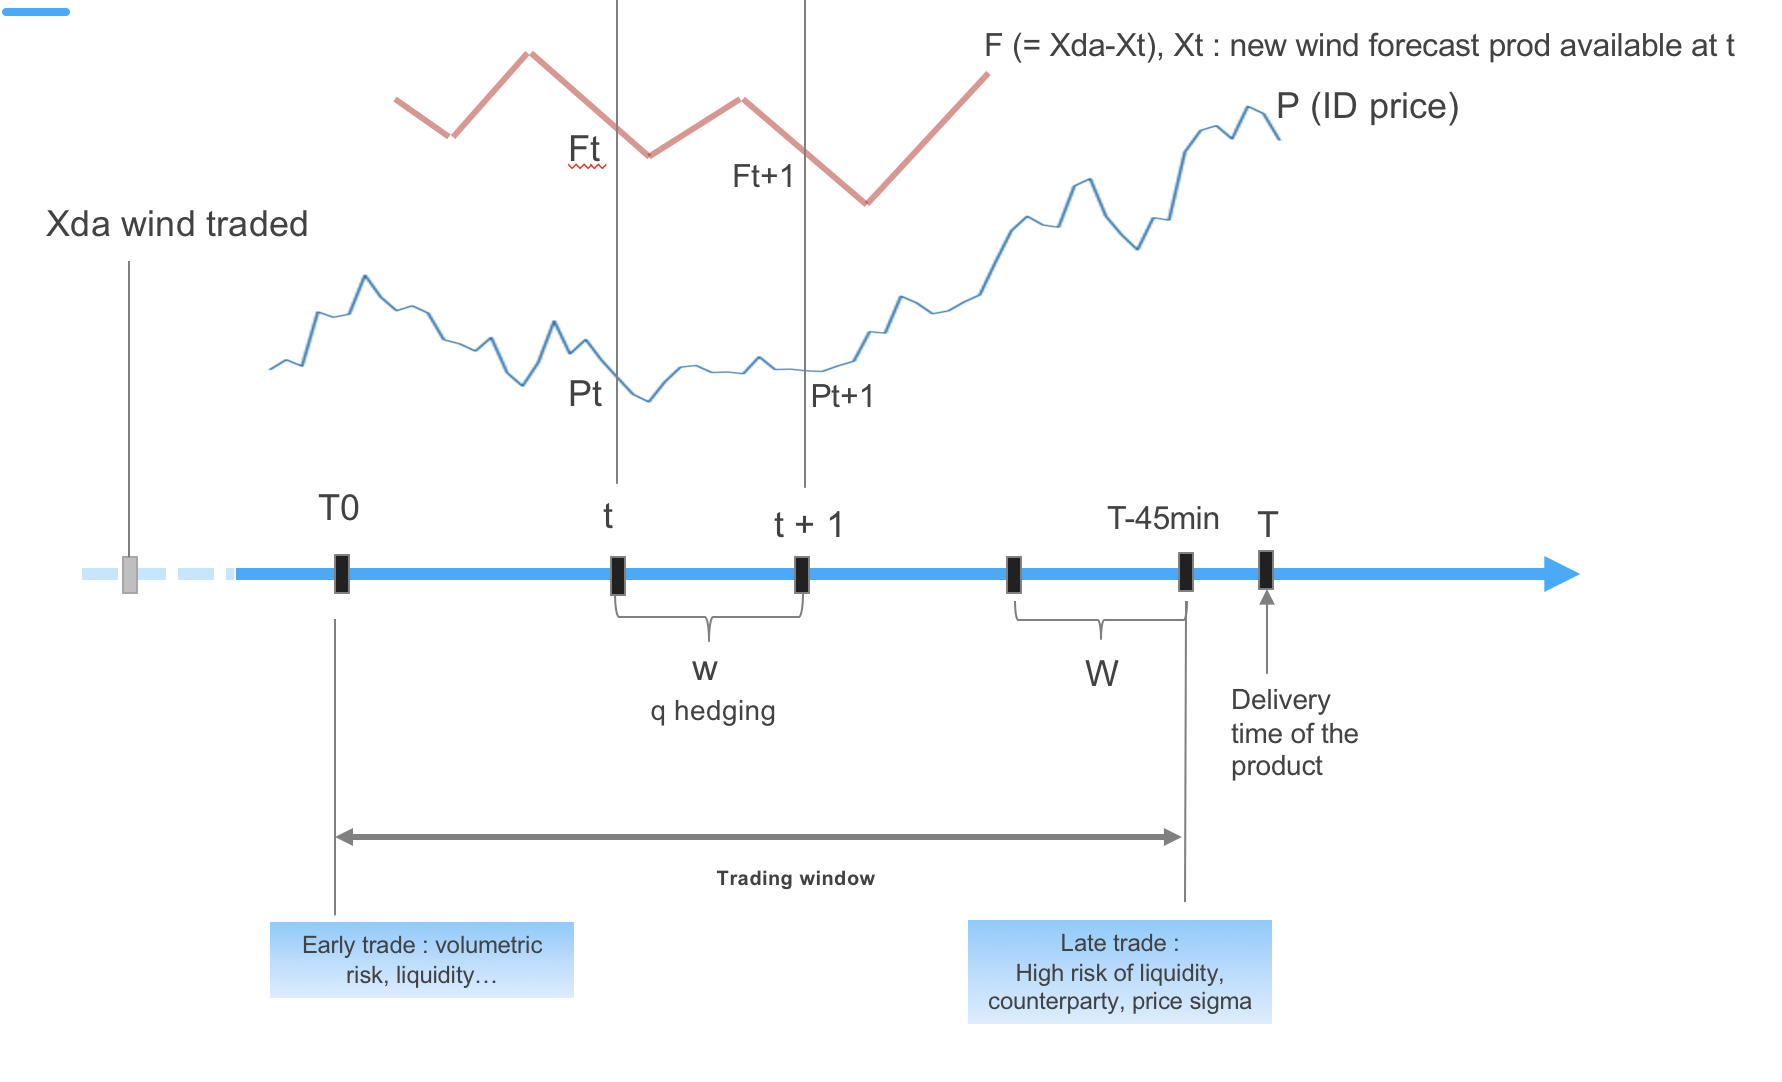

In [15]:
from IPython.display import Image
Image("model_pres.png" )

#### Calibration of the Price and forecast model parameters with historical data 

The goal is to estimate the parameters $\sigma_P$, $\mu_p$, $\sigma_F$ and $\rho_{PF}$ of the GBM and ABM formulas (under the historical measure). The associated log likelihood maximization leads to the following formulas for parameters estimation :

- $\sigma_P^{estimated} = \frac{std(R)}{\sqrt{\Delta t}}\quad\quad R = \{ log(\frac{P_{t+1}}{P_t})$ , t }
- $\mu_P^{estimated} = \frac{E[R]}{t} + \frac{\sigma_P^2}{2}$ 


**RESULTS**

- This calibration process has been made with EPEX data, we analyze the set of intraday deal over four years (2015-2018).

- A study of Intraday data shows that most of trades occure between 6H and 45min before delivery The estimation is based on random selection of 1000 days and ten hours products in each day with 3 time repetition. It resulted that $\sigma_P^{estimated}=0.021$  and     $\mu_P^{estimated}=0.0005$.

- A study of the price volatility for each hour to delivery has also been performed. It shows that the mean volatility remains quite constant at any time except during the last hour before delivery where it increases but in pratice we rarely want to trade at this moment.

- An other study shows that the price growth $m_P$ and price volatility are correlated to the price level. Indeed, both increase for very high or very low ID prices.
- To conclude, the hypothesis of a constant volatility along the trading session is rather a good assumption but one may try using a non constant volatility of kind $\sigma_P = \sigma_P(P_t)$ 

#### Define a routine that generate price and production forecast error evolution tree nodes

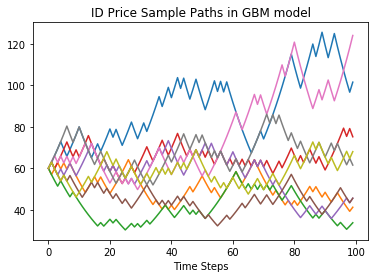

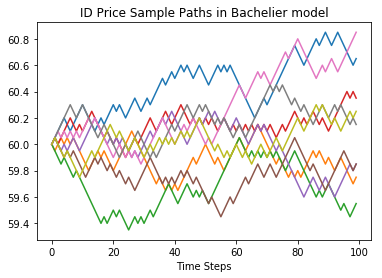

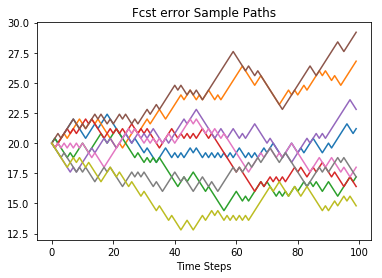

In [2]:
def Tree_path(#set parameter
                init_price = 60,
                init_forecast = 20,
                sigma_f = 0.4, # forecast volatility 
                sigma_p = 0.05, # = sigma_P_est  #intraday price volatility
                mu_p = 0.005, # = mu_P_est #intraday price growth
                mu_f = 0, # forecast growth 
                rho_fp = 0.3, #correlation between ID price and forecast processes
                M = 10, #number of tree time step (taken as frequency of the forecast update in our case) = number of trading windows (=W)
                T = 10, # delivery 
                delta_t = 1,
                price_dynamic = 'ABM'
                ): #= T/nb_step)
    
    #unit up and down increment of Price
    if price_dynamic == 'GBM':
        u_p = math.exp((mu_p - 0.5*sigma_p**2)*delta_t + sigma_p*math.sqrt(delta_t) )
        d_p = math.exp((mu_p - 0.5*sigma_p**2)*delta_t - sigma_p*math.sqrt(delta_t) )
    if price_dynamic == 'ABM':
        u_p = mu_p*delta_t + sigma_p*math.sqrt(delta_t)
        d_p = mu_p*delta_t - sigma_p*math.sqrt(delta_t)   
        
    #unit up and down increment of Forecast error
    u_f = sigma_f*math.sqrt(delta_t)
    d_f = -sigma_f*math.sqrt(delta_t)

    ID_prices = np.zeros((M, M))
    forecast = np.zeros((M, M))

    ID_prices[0,0] = init_price # in €/MWh
    forecast[0,0] = init_forecast #MWh

    #compute the evolution of price and forecast matrix error until terminal state
    for i in range(0,M):
        for j in range(0,M):
            
            if price_dynamic == 'GBM':
                ID_prices[i,j] = ID_prices[0,0]*u_p**(i-j)*d_p**j  
            if price_dynamic == 'ABM':
                ID_prices[i,j] = ID_prices[0,0] + (i-j)*u_p + j*d_p
                
            forecast[i,j] = forecast[0,0] + (i-j)*u_f + j*d_f        
    
    return ID_prices, forecast, u_p, d_p, u_f, d_f


##plot M  price and forecast error diffusion in binomial model to check
init_price = 60
init_forecast = 20
sigma_f = 0.4 # forecast volatility 
sigma_p = 0.05 # = sigma_P_est  #intraday price volatility
mu_p = 0. # = mu_P_est #intraday price growth
mu_f = 0 # forecast growth 
delta_t = 1

#unit up and down increment of Price
u_p = math.exp((mu_p - 0.5*sigma_p**2)*delta_t + sigma_p*math.sqrt(delta_t) )
d_p = math.exp((mu_p - 0.5*sigma_p**2)*delta_t - sigma_p*math.sqrt(delta_t) )
u_p1 = mu_p*delta_t + sigma_p*math.sqrt(delta_t)
d_p1 = mu_p*delta_t - sigma_p*math.sqrt(delta_t) 
#unit up and down increment of Forecast error
u_f = sigma_f*math.sqrt(delta_t)
d_f = -sigma_f*math.sqrt(delta_t)


MC = 9
M2 = 100
F = np.zeros((MC,M2))
F[:,0] = 20
P = np.zeros((MC,M2))
P[:,0] = 60
P1 = np.zeros((MC,M2))
P1[:,0] = 60
for m in range(MC): 
    for t in range(1,M2):
        N1 = random.random()
        N2 = random.random() 
        P[m,t] = P[m,t-1]*u_p*(N1 < 0.5 ) + P[m,t-1]*d_p*(N1 >= 0.5 )
        P1[m,t] = P1[m,t-1]+ mu_p + u_p1*(N1 < 0.5 ) + d_p1*(N1 >= 0.5 )
        F[m,t] = F[m,t-1] + u_f*(N2 < 0.5 ) + d_f*(N2 >= 0.5 )


plt.plot(P.T)
plt.xlabel('Time Steps')
plt.title('ID Price Sample Paths in GBM model')
plt.show()

plt.plot(P1.T)
plt.xlabel('Time Steps')
plt.title('ID Price Sample Paths in Bachelier model')
plt.show()

plt.plot(F.T)
plt.xlabel('Time Steps')
plt.title('Fcst error Sample Paths')
plt.show()

### Define our trade value function

Let's consider a trading windows 𝑤 in Ⱳ that begins at time t with the corresponding $F_t$ forecast error and price $P_t$. There are two options for the trader:

- Immediately trade $q_t$ in the market (either a positive or negative quantity)
- Do nothing ( $q_t$ = 0 )

The idea is to evaluate the trade-off between an immediate and a postponed trade to balance the forecast error.

We have to find a balance between excessively trades which lead to many transaction cost (and double trade), early trade (volumetric risks) and waiting too long which leads to risks (risk of liquidity, finding a counterparty, high volatility close to delivery...)

The unit cost of posponing a trade is given by (Garnier and Madlener 2014):

$$ C_t^b = (1 - \phi_e)(\Delta P + \frac{1}{2}sign(F_t)\Delta C_s ) + \phi_e(C_{ime} - P_t)$$

Where terms are precised below :

- $\phi_e$ : counterparty risk
- $\Delta P$ : intraday price change (consider $\frac{\Delta P}{P}$ instead )
- $\Delta C_s$ : Change in bid ask spread between window w and w-1
- $C_{ime}$ : cost of balancing untraded forecast error in imbalance market 

The costs of double trading for every unit traded in excess can be formulated as (Garnier and Madlener 2014) :

$$ C_t^d = sign(F_t)(TC + \frac{C_s}{2})  +  (1 - \phi_0)( -\Delta P + sign(F_t)( TC + \frac{\Delta C_s+ C_s}{2} ) ) + \phi_0(P_t - C_{imo})$$
 
 Where :
 
 - TC stand for transaction cost
 - $\phi_0$ : counterparty risk for double trade
 - $C_{imo}$ : costs of balancing an overestimated forecast error in the imbalance market.
 
 Total value of trading immediately for short position :
 
 $$V_{short}(q, t) = \int_q{1_{q\leq F_W}C_t^bdq} - \int_q{1_{q>F_W}C_t^ddq}$$
 
 where we consider $F_W$ the forecast error is the most accurate known ( $F_W = F_{T-45min}$) instead of $F_T$, 
 And for long position :
 
 $$V_{long}(q,t) = - \int{1_{q\leq F_W}C_t^ddq} + \int{1_{q>F_W}C_t^b dq}$$
 
 We can define the value function as : $$V(q,t) = 1_{current-position \leq F_W}V_{short}(q, t) + 1_{current-position > F_W}V_{long}(q, t)$$
 
 

In [2]:
## set up parameters for base model
phi_e = 0.3 #counterparty risk market trade
phi_o = 0 #counterparty risk counter trade
c_ime = 1.7 #imbalance market surcharge vs market trade
c_imo = 1 #imbalance market 
c_s = 0.05 #bid-ask spread
delta_c_s = 0.25 #spread growth of bid-ask spread
TC = 0.1 #transaction costs

#### Routine for cost and value calculation

In [4]:
#definition of these values with F being reforecast to be rebanced (F = wind reforcast - current position)

#cost of report a trade
def cost_b( P, delta_P, sign_F, c_ime, phi_e, delta_c_s):
    cb = (1 - phi_e)*(delta_P + 0.5*sign_F*delta_c_s) + phi_e*(c_ime - P)

    return cb

#cost of double trade
def cost_d( P, delta_P, sign_F, c_imo, TC, phi_o, delta_c_s):
    cd = sign_F*(TC + c_s/2) + (1 - phi_o)*(- delta_P + sign_F*(TC + (delta_c_s + c_s)/2)) + phi_o*( - c_imo  + P)

    return cd

def v_trade( F, P, q, delta_P, sign_F, c_ime, phi_e, c_imo, TC, phi_o, delta_c_s):
    #sum_cd = - cost_d( P, delta_P, sign_F, c_imo, TC, phi_o)*max([0,(q-F)])
    unit_cost_c = cost_d( P, delta_P, sign_F, c_imo, TC, phi_o, delta_c_s)
    unit_cost_b = cost_b( P, delta_P, sign_F,c_ime, phi_e, delta_c_s)
    #tot_cost = unit_cost_b*min(F,q) - unit_cost_c*unit_cost_b*(max([0,(q-F)]))**2
    tot_cost = (unit_cost_b*min(F,q)*(q>0) - (q>F)*(q-F)*unit_cost_c - q*(q<=0)*unit_cost_c)*(F>0) \
                + (unit_cost_b*max(F,q)*(q<0) - (q<F)*(q-F)*unit_cost_c - q*(q>0)*unit_cost_c)*(F<=0)
    
    return tot_cost




### Optimization scheme

In the optimization process, the lattice is used simultaneously for two purposes :

- identify the optimal volume for an immediate trade $q_w$ ( = $q_t$ with t begining time of window $w$)  regarding $F_t$ and remaining uncertainty
- estimate the added value of not trading now and wait for following windows

We proceed backward in time windows starting with the terminal condition $q_{T} = q_W = F_W$ where final forecast 
error is the most accurate  known. ( $F_W = F_{T-45min}$)

 Using 𝐶b and given that 𝑊 is the last available intraday trade window, the value of trading equals the difference between the current intraday price and the expected imbalance market price for the required balancing volumes, for the case that a trade partner can be found :
 
 
Following the Bellman principle and replacing values, Our value function to maximize at time t take the following form from time t:

 $$V_t(q_t*)= \max_{q}{\big[V(q,t) + \max_{q}{E (V(q,t+1) | t, P_t, F_t)\big]}} = max\big(V(q,t) + \max_{q}{\sum_{P_{t+1}, F_{t+1}}{proba(P_{t+1}, F_{t+1}| P_t, F_t))V(q,t+1) }}\big) $$
 
 $$=\quad...\quad=  max\big(V(q,t) + \max_{q}{\sum_{P_{W}, F_{W}}{proba(P_{W}, F_{W}| P_t, F_t))V(q,W) }}\big) $$
 
 where $V$ is the value function defined above

 where M is the number of possible combination price-production forecast error along with their probability $p_m$ from time t to end of last windows W and the $\Delta P$ in unit cost $C_t^b$ and $C_t^d$ formulas are the cumulative delta price till the last time 
 
The value of immediately trading the value-maximizing volume qt
∗ must then be compared to
the discounted sum of the four probability-weighted values of holding on to the option to
trade until the next trade window.

Starting with terminal condition : $U(q_W*) = V(q_{W}*) = V(q_{T-1}*)$

At each step we compute : 

$\quad\quad V(q_t*)\quad\quad$  and  $\quad\quad U(q_t*) = \max{(V(q_t*), \frac{p_{uu}U(q_{t+1}*)_{uu}+p_{ud}U(q_{t+1}*)_{ud}+p_{du}U(q_{t+1}*)_{du}+p_{dd}U(q_{t+1}*)_{dd}}{1+\tau})}$

where $p_{uu}$, $p_{ud}$, $p_{du}$, $p_{dd}$ are the transition probabilities for forecast and price discrete random evolution. It correspond to a risk-neutral probability
We assume that $p_{uu} = p_{ud} = p_{du} = p_{dd} = 0.25$.

Here $\tau$ is a discount factor,  it
reflects the increase in counterparty risk between the current and the next trade window

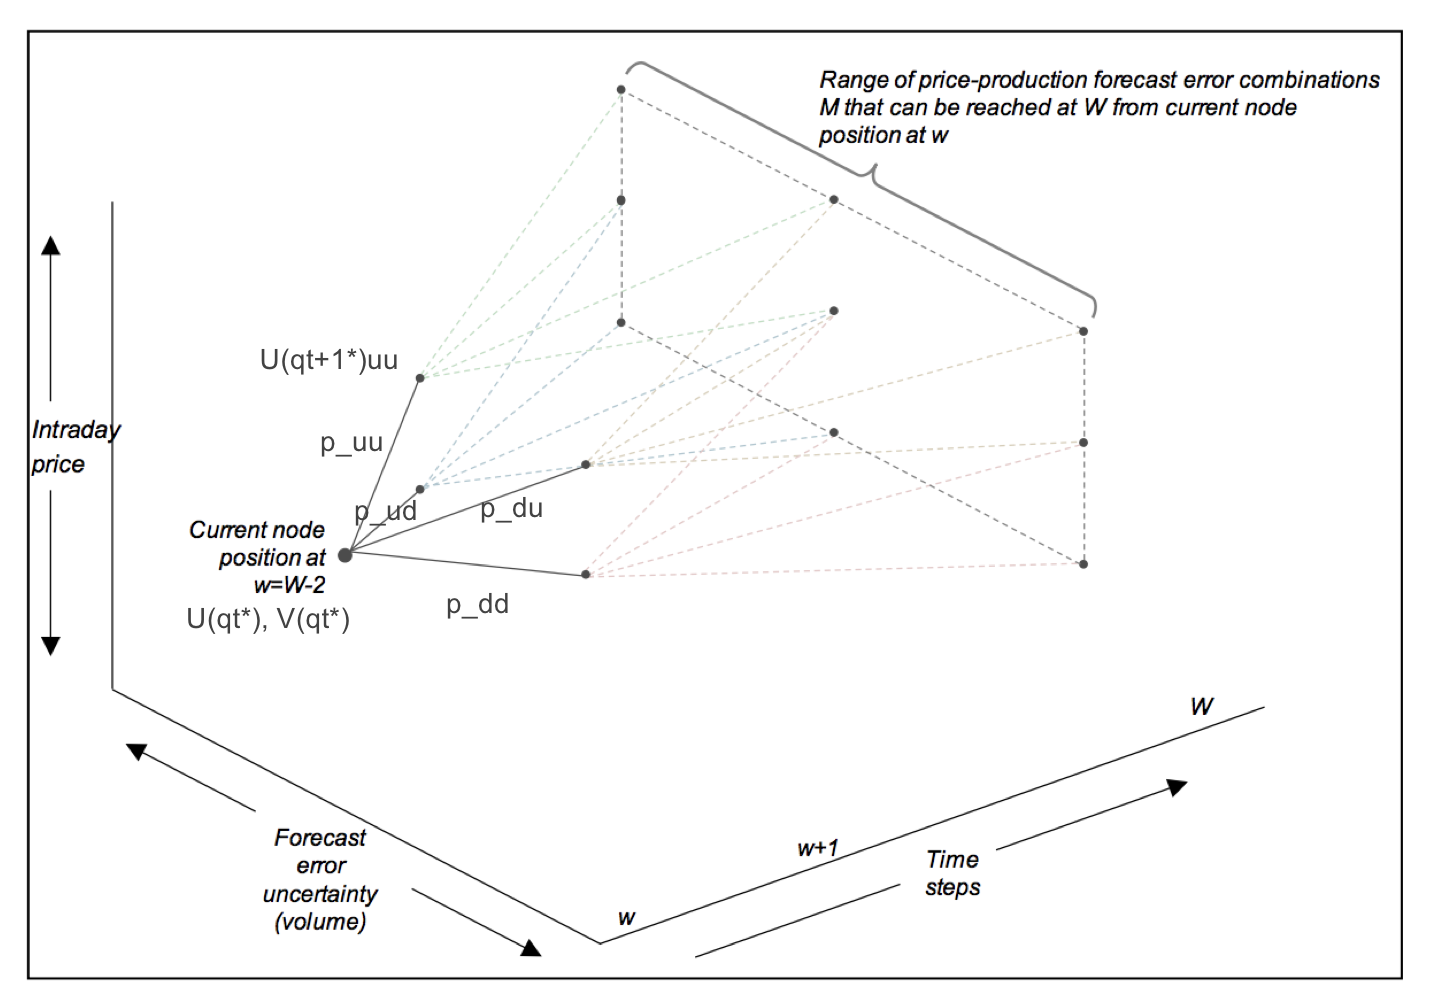

In [37]:
Image("opt.png", width = 700, height =700)

#### Other approach, discussions

- An other possible approach could be to use a Least square Monte Carlo scheme by directly simulate Monte carlo pathes for P and F and then backward optimize V(q) at step t with a mean-square regression.

**Set default transition probability including correlation**

In [5]:
#set default transition probability including correlation
rho = 0.3  
p_uu = 0.25*(1+rho)
p_ud = 0.25*(1-rho)
p_du = 0.25*(1-rho)
p_dd = 0.25*(1+rho)
#discounted factor
tau_c = 0.3

#### Define value to be optimize at each step of optimization process

In [6]:
from scipy.stats import multinomial

#compute at time t the value of conditional expectation of trade value at terminal step
#to be maximize for short and long position
# starting from the (i,j)th combination price & fcst at time t
def expected_value(params, *args, **kwargs):
    
    q = params
    init_position,forecast,ID_prices,u_p,d_p,u_f,d_f,price_dynamic,rho, i,j,t,c_ime, phi_e, c_imo, TC, phi_o, delta_c_s = \
    args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9] , args[10], args[11], args[12],\
    args[13], args[14], args[15], args[16], args[17]
    
    M = ID_prices.shape[0]
    p_uu = 0.25*(1+rho)
    p_ud = 0.25*(1-rho)
    p_du = 0.25*(1-rho)
    p_dd = 0.25*(1+rho)
    
    rv = multinomial(M-t, [p_uu, p_ud, p_du,p_dd])
    #print('phie',phi_e/2**(M-t-1))
    if t==M:
        v = (1-phi_e)*params*(c_ime - ID_prices[M-1,i])
        return v
    
    else:
        v = 0
        for x1 in range(0,M-t+1):
            for x2 in range(0,M-t+1):
                for x3 in range(0,M-t+1):
                    for x4 in range(0,M-t+1):
                        if x1+x2+x3+x4 == (M-t):
                            
                            #forward projection of price, price change and forecast error possible scenario
                            F = init_position - (forecast[t,j] + (x1+x2)*u_f + (x3+x4)*d_f )
                            if price_dynamic == "GBM":
                                P = ID_prices[t,i]*u_p**(x1+x3)*d_p**(x2+x4)
                                delta_P = P - ID_prices[t,i]
                            if price_dynamic == 'ABM':
                                P = ID_prices[t,i] + (x1+x3)*u_p + (x2+x4)*d_p
                                delta_P = P - ID_prices[t,i]

                            #current F sign
                            if F == 0:
                                sign_F = 1
                            else:
                                sign_F = F/abs(F) 


                            p_m = rv.pmf([x1,x2,x3,x4])

                            v = v + p_m*v_trade(F = F,
                                                P = P,
                                                q = q,
                                                delta_P = delta_P ,
                                                sign_F = sign_F,
                                                c_ime = c_ime,
                                                phi_e = phi_e/2**(M-t-2),
                                                c_imo= c_imo,
                                                TC = TC,
                                                phi_o = phi_o/2**(M-t),
                                                delta_c_s = delta_c_s/2**(M-t)) 

        return -v



#### Routine for fitting a minimization process of a function of one variable

In [7]:
import scipy.optimize as op
from scipy.optimize import minimize, fminbound, Bounds


def minimization(fun, init_guess, args, minval, maxval, kind):   

    #using scipy minimize
    if kind == 'scipy-min':
        bounds = op.Bounds(lb = minval, ub = maxval)
        res = op.minimize(fun,
                       x0=init_guess,
                       args = args,
                       bounds = bounds,
                       method='BFGS',
                       options={'disp': False,
                                'maxiter': 50})
        
        return res.x, res.fun

    #using scipy fminbound
    if kind == 'scipy-minbd':
        res = fminbound(func = fun,
                        x1 = minval,
                        x2 = maxval,
                        args=args,
                        xtol=1e-05,
                        maxfun=50,
                        full_output=True,
                        disp=1)
        
        return res[0], res[1]
    
    if kind == 'discrete':
        params = np.linspace(minval, maxval, 100)
        opt = np.argmin([fun(p, *args) for p in params ])
        fval = fun(opt, *args)

        return opt, fval
    
    else:
        
        return "bad kind entry, must be 'naive', 'scipy-minbd' or 'discrete'"

#### Routine for optimization step for a particular trading time and particular market setup

In [8]:


#put the precedent optim scheme in routine for optimization step starting at trading windows w
#consider tree_time_step corresponding to each future trading windows, 
def optimal_hedge(
                  ID_prices,
                  forecast,
                  u_p, d_p, u_f, d_f,
                  price_dynamic,
                  init_position, #initial position at the begining of current windows
                  rho = 0.3, #corrrelation btween the two process
                  TC = 0.1, #trans cost
                  c_ime = 1.7, #imbalance market surcharge vs market trade
                  c_imo = 1, #imbalance market 
                  tau_c = 0.3, # discount rate (dynamically adjusted)
                  phi_e = 0.3, #counterparty risk market trade at terminal step
                  phi_o = 0, #counterparty risk counter trade at terminal step
                  delta_c_s = 0.25, #bid ask spread at terminal step
                  optim_method = 'scipy-minbd',
                  verbose = False #wether to show intermediate values
                 ):
    
    M = ID_prices.shape[0]  #nb of step
    
    p_uu = 0.25*(1+rho)
    p_ud = 0.25*(1-rho)
    p_du = 0.25*(1-rho)
    p_dd = 0.25*(1+rho)

    #initialize the 3th order tensor 
    V_star = np.zeros((M, M, M))#immediately trading values
    U_star = np.zeros((M, M, M))#optimal trading values
    q_star = np.zeros((M, M, M))#optimal hedges (quantities that max values)

    #set up terminal condition according to the article 
    for i in range(0,M):
        for j in range(0, M):
            q_star[i,j,M-1] =  -forecast[M-1,j] + init_position
            U_star[i, j, M-1] = (1-phi_e)*q_star[i,j,M-1]*(c_ime - ID_prices[M-1,i])
            V_star[i,j,M-1] = (1-phi_e)*q_star[i,j,M-1]*(c_ime - ID_prices[M-1,i])
            
    
    if M <=0:
        return "nothing to optimize"
    
    if M == 1:
        return q_star, U_star
    
    
    #Backward recursion for optimization step
    for w in range(M-2,-1,-1): # backward loop on time step

        #update dynamically adjusted parameters for base asumption
        tau_c = phi_e/2**(M-w-2)
        #print("tauc",tau_c)
        
        for i in range(w+1): #loop on (F,P) combination (i,j)
            for j in range(w+1):  
                # compute optimal Vq for immediate trade (use scipy minimize instead)
                
                ##----maximization of conditional expectation of trade value at terminal step 
                maxval = init_position - (forecast[w,j] + (M-1-w)*d_f)
                minval = init_position - (forecast[w,j] + (M-1-w)*u_f)
                q_star[i,j,w], V_star[i,j,w] = minimization(expected_value,
                                                            init_guess=0, #forecast[w,j],
                                                            args=(init_position,forecast,ID_prices,u_p,d_p,u_f,d_f,price_dynamic,rho,i,j,w,c_ime, phi_e, c_imo, TC, phi_o, delta_c_s),
                                                            minval= minval,
                                                            maxval= maxval,
                                                            #minval =-10,
                                                            #maxval=10,
                                                            kind=optim_method)
                    
        
                V_star[i,j,w] = - V_star[i,j,w]
                 
                u_uu = U_star[i, j, w+1]
                u_du = U_star[i+1, j, w+1]
                u_ud = U_star[i, j+1, w+1]
                u_dd = U_star[i+1, j+1, w+1]
                U_update = (p_uu*u_uu + p_du*u_du + p_ud*u_ud + p_dd*u_dd)/(1 + tau_c) #value to wait
                U_star[i,j,w] = max(V_star[i,j,w], U_update) #update utility function 
                
                #trading decision process
                if U_star[i,j,w] > V_star[i,j,w]:
                    q_star[i,j,w] = 0


        if verbose == True:
            print('')
            print("############## Values of immediate trades at time " + str(w) +" ######################")
            df_V = pd.DataFrame(data = V_star[:w+1,:w+1,w] , index = range(w+1), columns = range(w+1))
            print(df_V)
            print('  ')
            print("############## policies of immediate trades at time " + str(w) +" ######################")
            df_q = pd.DataFrame(data = q_star[:w+1,:w+1,w] , index = range(w+1), columns = range(w+1))
            print(df_q)
            print('')

    return q_star, U_star



#### Run optimization start from t=0

In [170]:
#contruct remaining price & fcst uncertainty lattice starting from availables values at t until last time T 
ID_prices, forecast, u_p, d_p, u_f, d_f = Tree_path( init_price = 60,
                                                    init_forecast = 20,
                                                    sigma_f = 0.4,  
                                                    sigma_p = 0.02, 
                                                    mu_p = 0.001, 
                                                    mu_f = 0.4, 
                                                    rho_fp = 0.3, 
                                                    M = 5, 
                                                    delta_t = 1,
                                                   price_dynamic = 'ABM')
#run optim process
q, U = optimal_hedge(ID_prices,
                     forecast,
                     u_p, d_p, u_f, d_f,
                     price_dynamic = 'ABM',
                     init_position = 22,
                     TC = 1, #trans cost
                     c_ime = 1.7, #imbalance market surcharge vs market trade
                     c_imo = 1, #imbalance market 
                     tau_c = 0.3, # discount rate (dynamically adjusted)
                     phi_e = 0.3, #counterparty risk market trade
                     phi_o = 0, #counterparty risk counter trade
                     delta_c_s = 0.25,
                     optim_method = 'scipy-minbd',
                     verbose = True
                     )



############## Values of immediate trades at time 3 ######################
          0          1          2          3
0 -5.453132 -19.442112 -33.431092 -47.420072
1 -5.449532 -19.428912 -33.408292 -47.387672
2 -5.445932 -19.415712 -33.385492 -47.355272
3 -5.442332 -19.402512 -33.362692 -47.322872
  
############## policies of immediate trades at time 3 ######################
          0         1         2         3
0  0.400004  1.200004  2.000004  2.800004
1  0.400004  1.200004  2.000004  2.800004
2  0.400004  1.200004  2.000004  2.800004
3  0.400004  1.200004  2.000004  2.800004


############## Values of immediate trades at time 2 ######################
          0          1          2
0 -3.160479 -10.149214 -17.137949
1 -3.158379 -10.142314 -17.126249
2 -3.156279 -10.135414 -17.114549
  
############## policies of immediate trades at time 2 ######################
          0         1         2
0  0.400006  1.200006  2.000006
1  0.400006  1.200006  2.000006
2  0.400006  1.20000

### Test for some scenarios

####  forward path routine  of a complete trading session with re-optimization at each trading window

- The routine include the evaluation of three others strategies :
    - Always trade : trade the delta at every new data publication
    - Start-end-trade : trade at the first new reforcast (Delivery - 4H for example) and trade the remaining delta at the last trading windows
    - end-trade : only trade at the end

In [9]:

#routine for model strategy on forward path

def bidding_model(init_position = 19, #correspond to day-ahead position
                  init_IDprice = 60,
                  init_forecast = 20, #first wind production reforcast (at the beginning of trading session)
                  rho = 0.3, #corrrelation btween the two process
                  nb_trading_window = 10,
                  delta_t = 1,
                  sigma_p = 0.1,
                  mu_p = 0.,
                  sigma_f = 0.4,
                  TC = 0.1,
                  c_ime = 1.7, #imbalance market surcharge vs market trade
                  c_imo = 1, #imbalance market 
                  tau_c = 0.3,# discount rate (dynamically adjusted)
                  phi_e = 0.3,#counterparty risk market trade at terminal step
                  phi_o = 0.3,#counterparty risk counter trade at terminal step
                  delta_c_s = 0.25, #bid ask spread at terminal step, dynamically adjusted 
                  #price dynamic = 'ABM', #'GBM'
                  optim_method = 'scipy-minbd',
                  price_dynamic = 'ABM',
                  verbose = False #wether to show intermediate values
                 ):

    #initiate trades,  position and market values
    W = nb_trading_window    
    

    F = np.zeros(W)
    F[0] = init_forecast
    P = np.zeros(W)
    P[0] = init_IDprice


    
    #initialize values arrays of each trades model 
    model_trades = np.zeros(W) 
    #other alternative trading strat
    always_trades = np.zeros(W)
    start_end_trade = np.zeros(W)
    end_trades = np.zeros(W)
    overall_model_value = np.zeros(W)
    
    model_value = np.zeros(W) 
    #other trading strat
    always_trades_value = np.zeros(W)
    start_end_trade_value = np.zeros(W)
    end_trades_value = np.zeros(W)

    model_position = np.zeros(W)
    model_position[0] = init_position
    #other trading strat
    always_trades_position = init_position
    start_end_trade_position = init_position
    end_trades_position = init_position
    
    
    for t in range(0,W):
            
        
        #print(t)
        #compute the new change in price and forecast error 
        if t>0:
            #update price and forecast vol to be more realistic in path generation
            #sigma_p = sigma_p*1.5
            sigma_f = sigma_f/1.1

   
            
            #update price and forecast using discrete SDE path
            N1 = np.random.normal(loc=0.0, scale=1.0, size=None)
            N2 = np.random.normal(loc=0.0, scale=1.0, size=None)
            P[t] = P[t-1]*math.exp((mu_p - 0.5*sigma_p**2)*delta_t + sigma_p*math.sqrt(delta_t)*N1 )
            F[t] = F[t-1] + sigma_f*math.sqrt(delta_t)*(rho*N1 + math.sqrt(1-rho**2)*N2)
            
        
        #contruct remaining price & fcst uncertainty lattice starting from availables values at t until last time T 
        ID_prices, forecast, u_p, d_p, u_f, d_f = Tree_path(init_price = P[t],
                                                            init_forecast = F[t],
                                                            sigma_f = sigma_f,  
                                                            sigma_p = sigma_p, 
                                                            mu_p = mu_p, 
                                                            mu_f = 0, 
                                                            rho_fp = rho, 
                                                            M = W-t, 
                                                            delta_t = 1,
                                                            price_dynamic = price_dynamic)


        #update always trades strategy
        always_trades[t] = - F[t] + always_trades_position
        always_trades_position = F[t]

        always_trades_value[t] = - expected_value(
                                         always_trades[t],
                                         always_trades_position,
                                         forecast,
                                         ID_prices,
                                         u_p, d_p, u_f, d_f,
                                         price_dynamic,
                                         rho,
                                         0,
                                         0,
                                         0,
                                         c_ime,
                                         phi_e,
                                         c_imo,
                                         TC,
                                         phi_o,
                                         delta_c_s )

        #update start end trades strategy
        if t ==0:
            start_end_trade[t] = - F[0] + start_end_trade_position

            start_end_trade_value[t] = - expected_value(
                                             start_end_trade[t],
                                             start_end_trade_position,
                                             forecast,
                                             ID_prices,
                                             u_p, d_p, u_f, d_f,
                                             price_dynamic,
                                             rho,
                                             0,
                                             0,
                                             0,
                                             c_ime,
                                             phi_e,
                                             c_imo,
                                             TC,
                                             phi_o,
                                             delta_c_s)



            start_end_trade_position = start_end_trade_position - start_end_trade[t]
            
        if t==W-1:
            start_end_trade[t] = - F[t] + start_end_trade_position

            start_end_trade_value[t] = - expected_value(
                                                 start_end_trade[t],
                                                 start_end_trade_position,
                                                 forecast,
                                                 ID_prices,
                                                 u_p, d_p, u_f, d_f,
                                                 price_dynamic,
                                                 rho,
                                                 0,
                                                 0,
                                                 0,
                                                 c_ime,
                                                 phi_e,
                                                 c_imo,
                                                 TC,
                                                 phi_o,
                                                 delta_c_s)


        
        #end trade strategy
        if t==W-1:
            end_trades[t] = - F[t] + end_trades_position

            end_trades_value[t] = - expected_value(
                                             end_trades[t],
                                             end_trades_position,
                                             forecast,
                                             ID_prices,
                                             u_p, d_p, u_f, d_f,
                                             price_dynamic,
                                             rho,
                                             0,
                                             0,
                                             0,
                                             c_ime,
                                             phi_e,
                                             c_imo,
                                             TC,
                                             phi_o,
                                             delta_c_s)

        
        #update our model strategy
        if t<W:
            q, U = optimal_hedge(ID_prices,
                                 forecast,
                                 u_p, d_p, u_f, d_f,
                                 price_dynamic=price_dynamic,
                                  init_position = model_position[t],
                                  rho=rho,
                                  TC = TC, 
                                  c_ime = c_ime, 
                                  c_imo = c_imo,  
                                  tau_c = tau_c, 
                                  phi_e = phi_e, 
                                  phi_o = phi_o ,
                                  delta_c_s = delta_c_s,
                                  optim_method = optim_method,
                                  verbose = False 
                                 )
            model_trades[t] = q[0,0,0]
            overall_model_value[t] = U[0,0,0]
            # compute model value

            model_value[t] = - expected_value(
                                         model_trades[t],
                                         model_position[t],
                                         forecast,
                                         ID_prices,
                                         u_p, d_p, u_f, d_f,
                                         price_dynamic,
                                         rho,
                                         0,
                                         0,
                                         0,
                                         c_ime,
                                         phi_e,
                                         c_imo,
                                         TC,
                                         phi_o,
                                         delta_c_s)
            
            if t<W-1:
                model_position[t+1] = model_position[t] - model_trades[t]
        #if t == W-1: #last trading windows
         #   model_trades[t] = model_position - F[t] 
          #  model_value[t] = (1-phi_e)*model_trades[t]*(c_ime - P[t])
           # model_position = 0
        
        result = pd.DataFrame([], index = range(W), columns = [])
        result['ID_price'] = P
        result['forecast_dev'] = F
        result['model_trades'] = model_trades
        result['model_value'] = model_value
        result['model_position'] = model_position
        #result['overall_model_value'] = overall_model_value
        result['always_trades'] = always_trades
        result['always_trades_value'] = always_trades_value
        result['start_end_trade'] = start_end_trade
        result['start_end_trade_value'] = start_end_trade_value
        result['end_trades'] = end_trades
        result['end_trades_value'] = end_trades_value

        arg_dict = {'init_position': init_position,
                  'init_IDprice' : init_IDprice,
                  'init_err_forecast' : init_forecast,
                  'corr_F_P': rho, #corrrelation btween the two process
                  'nb_trading_window': nb_trading_window,
                  'delta_t': delta_t,
                  'sigma_p' : sigma_p,
                  'mu_p' : mu_p,
                  'sigma_f' : sigma_f,
                  'TC' : TC,
                  'c_ime' : c_ime, #imbalance market surcharge vs market trade
                  'c_imo' : c_imo, #imbalance market 
                  'tau_c' : tau_c,# discount rate (dynamically adjusted)
                  'phi_e' : phi_e,#counterparty risk market trade at terminal step
                  'phi_o' : phi_o,#counterparty risk counter trade at terminal step
                  'delta_c_s' : delta_c_s, #bid ask spread at terminal step, dynamically adjusted }
                   }
        
    return result, P, F, arg_dict, model_position

final model position.......: [30.         20.40000074 20.40000074 20.40000074 20.40000074 20.47774786
 20.38911393 20.37742172 20.3168258  20.25598798]


,ID_price,forecast_dev,model_trades,model_value,model_position,always_trades,always_trades_value,start_end_trade,start_end_trade_value,end_trades,end_trades_value
0,60.000000,20.000000,9.599999,1.247764,30.000000,10.000000,-0.463502,10.000000,1.192581,0.000000,0.0000
1,59.674572,20.087808,0.000000,0.000000,20.400001,-0.087808,0.036325,0.000000,0.000000,0.000000,0.0000
2,58.859256,20.215334,0.000000,0.000000,20.400001,-0.127526,0.077418,0.000000,0.000000,0.000000,0.0000
3,56.031164,20.207631,0.000000,0.000000,20.400001,0.007703,0.003161,0.000000,0.000000,0.000000,0.0000
4,54.015989,20.136248,-0.077747,0.058856,20.400001,0.071383,-0.013183,0.000000,0.000000,0.000000,0.0000
5,56.963662,20.140750,0.088634,-0.173157,20.477748,-0.004502,0.006617,0.000000,0.000000,0.000000,0.0000
6,58.159758,20.208085,0.011692,-0.044753,20.389114,-0.067335,0.133203,0.000000,0.000000,0.000000,0.0000
7,66.314390,20.214199,0.060596,-0.528498,20.377422,-0.006114,0.032638,0.000000,0.000000,0.000000,0.0000
8,66.272905,20.209343,0.060838,-0.962657,20.316826,0.004856,-0.024616,0.000000,0.000000,0.000000,0.0000
9,73.496678,20.222689,0.033299,-0.697715,20.255988,-0.013346,0.295061,-0.222689,8.661758,9.777311,-420.0915


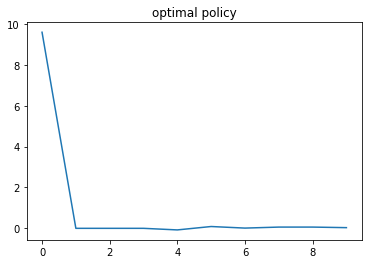

In [176]:

print("final model position.......:", final_pos)
result['model_trades'].plot(title = 'optimal policy along trading windows')
result

#### Repeat bidding_model function for several diff scenarios and with  different market states

#### Case of high volatility and price growth  starting with 4MW short position

processing scenario....0


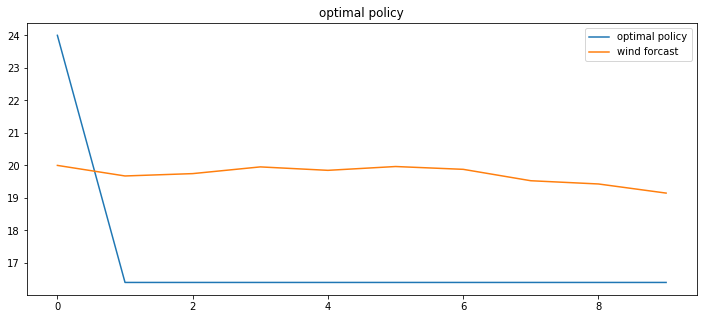

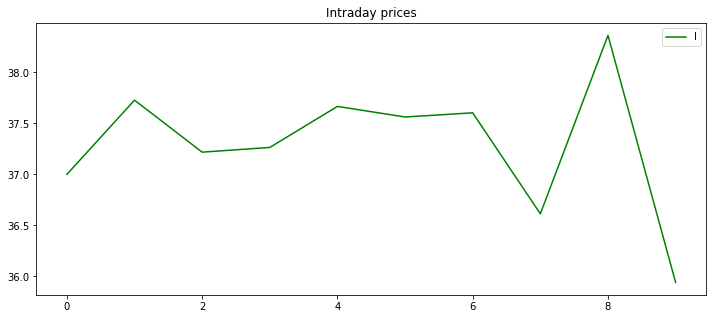

processing scenario....1


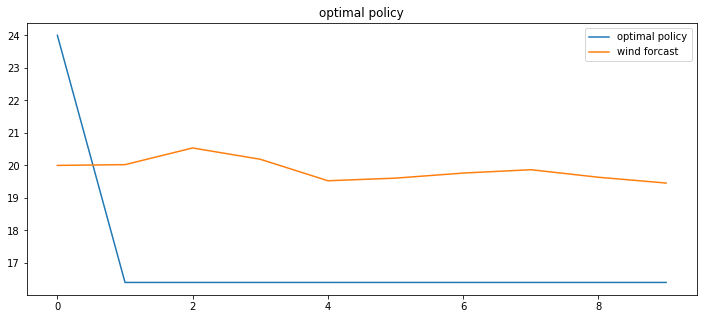

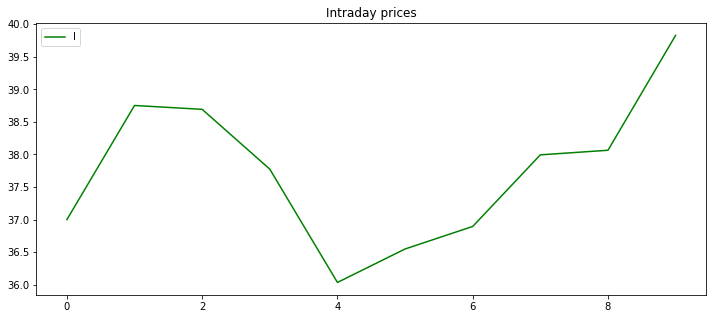

processing scenario....2


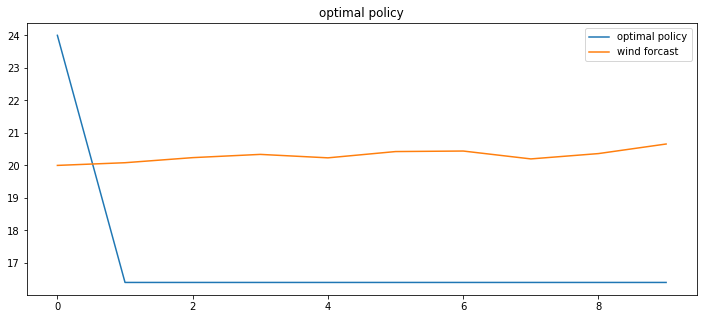

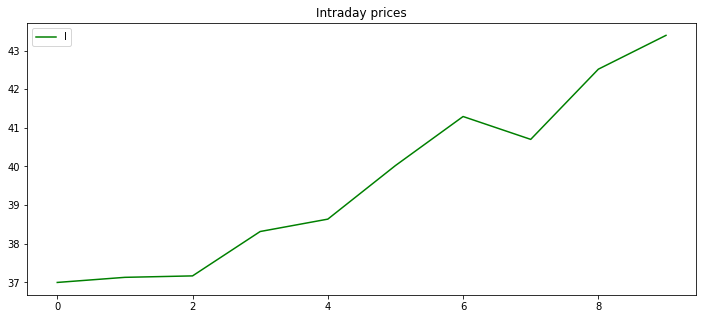

processing scenario....3


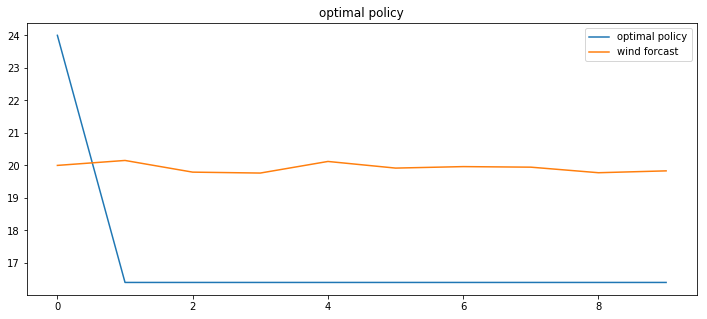

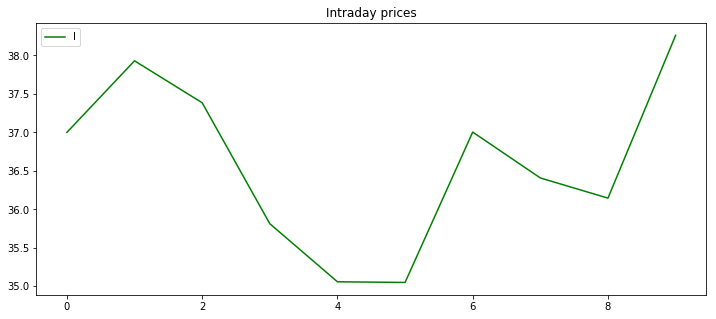

processing scenario....4


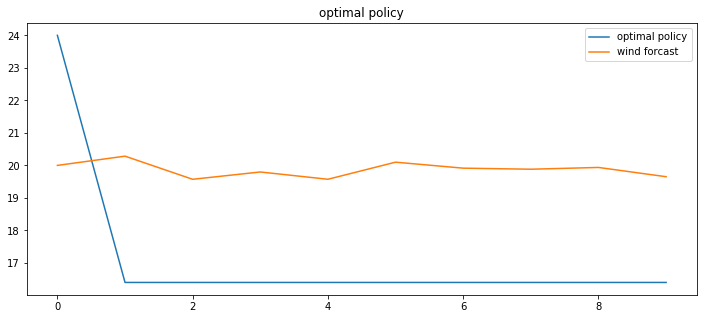

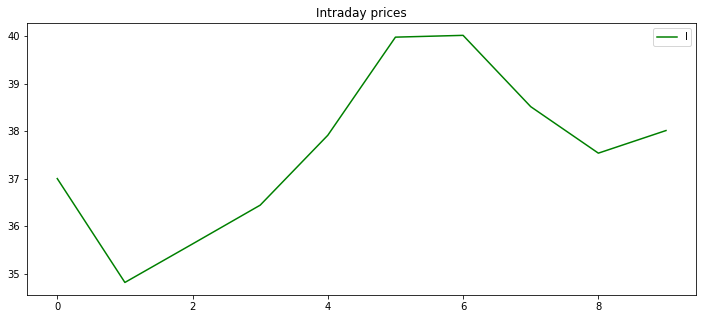

processing scenario....5


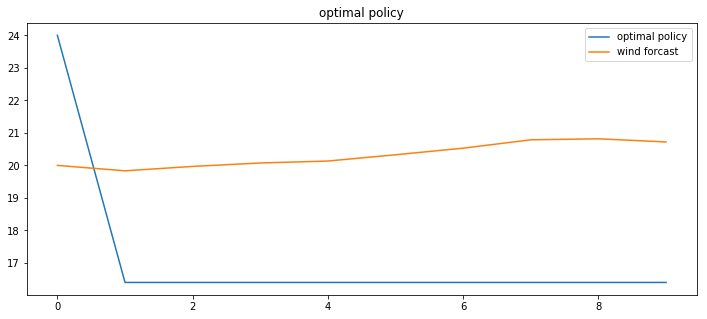

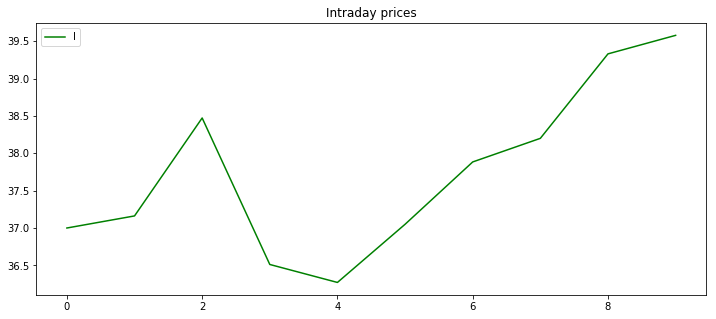

processing scenario....6


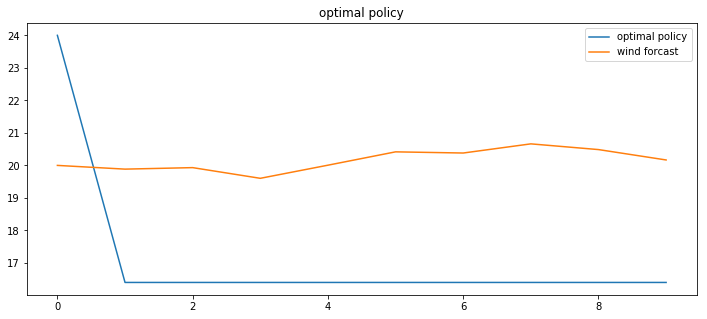

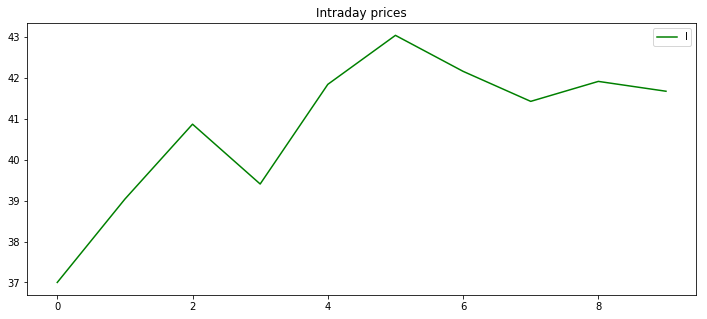

processing scenario....7


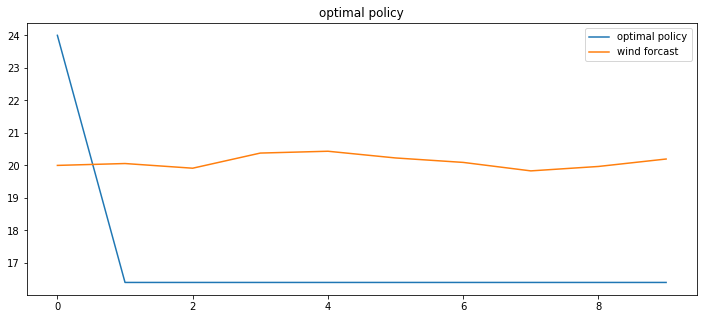

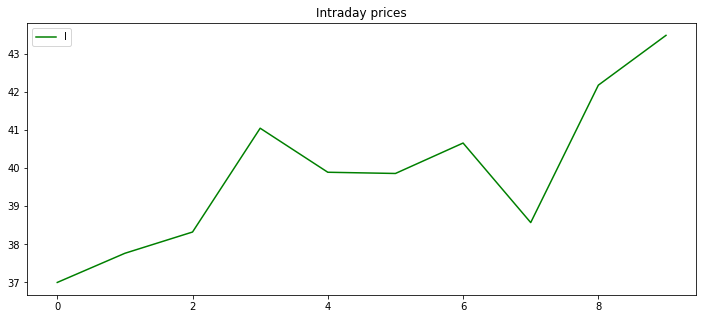

processing scenario....8


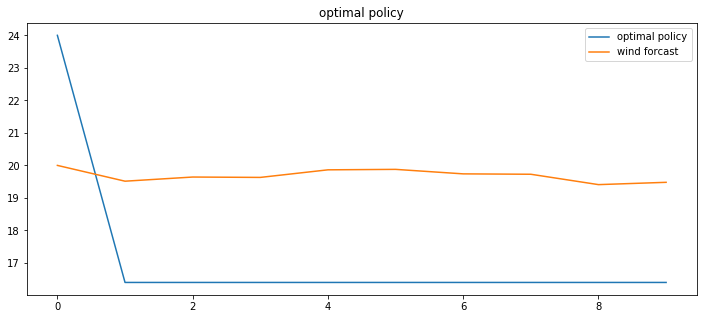

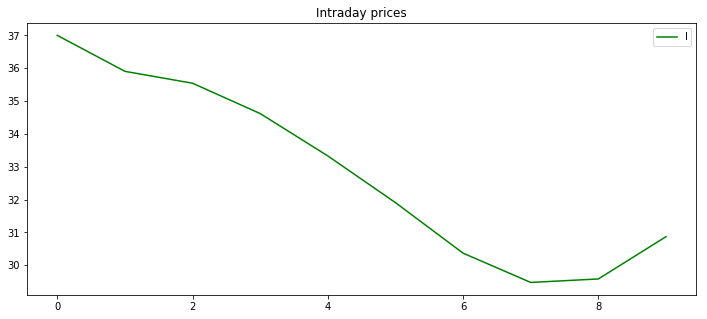

processing scenario....9


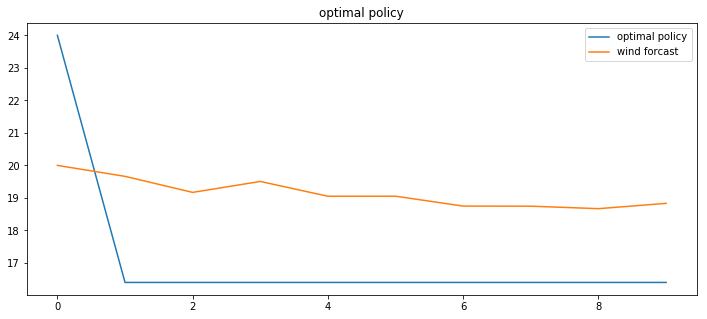

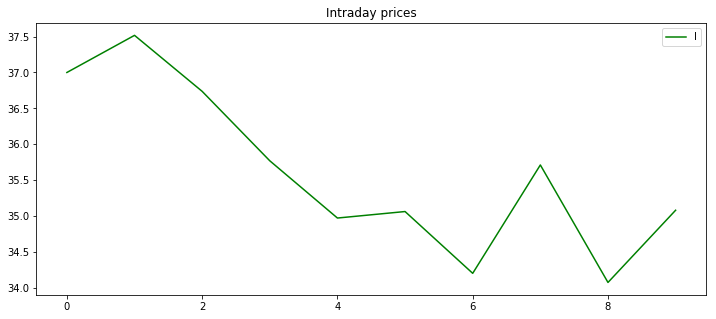

In [185]:
#bcase of high volatility and price growth  starting with 4MW short position

N_MC = 10

list_values = []
list_prices = []
list_forecast = []

for n in range(N_MC):
    print("processing scenario...." + str(n))
    result, P, F, arg_dict, final_pos = bidding_model(init_position = 24, #short init position of 10MW
                                      init_IDprice = 37,
                                      init_forecast = 20,
                                      rho = 0.3, #corrrelation btween the two process
                                      nb_trading_window = 10,
                                      delta_t = 1,
                                      sigma_p = 0.03,
                                      mu_p = 0.0012,
                                      sigma_f = 0.4,
                                      TC = 0.1,
                                      c_ime = 1.7, #imbalance market surcharge vs market trade
                                      c_imo = 1, #imbalance market 
                                      tau_c = 0.3,# discount rate (dynamically adjusted)
                                      phi_e = 0.3,#counterparty risk market trade at terminal step
                                      phi_o = 0,#counterparty risk counter trade at terminal step
                                      delta_c_s = 0.25, #bid ask spread at terminal step, dynamically adjusted 
                                      optim_method = 'scipy-minbd',
                                      price_dynamic = 'GBM',
                                      verbose = False #wether to show intermediate values
                     )
    ax = result['model_position'].plot(title = 'optimal policy', figsize= (12,5))
    result['forecast_dev'].plot(ax=ax)
    plt.legend(('optimal policy', 'wind forcast'))
    plt.show()
    result['ID_price'].plot(title = 'Intraday prices', figsize= (12,5), color = 'green')
    plt.legend(('ID price'))
    plt.show()
    list_values.append(result)
    list_prices.append(P)
    list_forecast.append(F)

init_position        24.000000
init_IDprice         37.000000
init_err_forecast    20.000000
corr_F_P              0.300000
nb_trading_window    10.000000
delta_t               1.000000
sigma_p               0.030000
mu_p                  0.001200
sigma_f               0.169639
TC                    0.100000
c_ime                 1.700000
c_imo                 1.000000
tau_c                 0.300000
phi_e                 0.300000
phi_o                 0.000000
delta_c_s             0.250000
dtype: float64


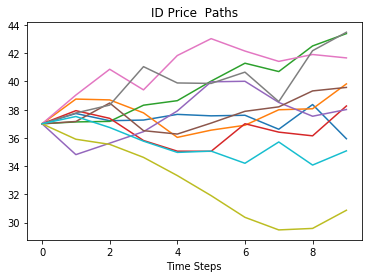

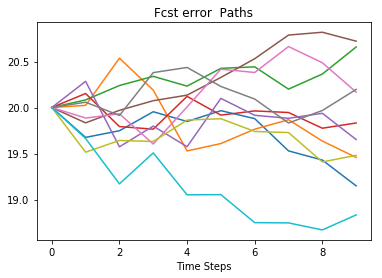

      ID_price  forecast_dev  model_trades  model_value  model_position  \
0    37.000000     20.000000      7.599994     2.328001       24.000000   
1    37.374301     19.917131      0.000000     0.000000       16.400006   
2    37.603161     19.851446      0.000000     0.000000       16.400006   
3    37.296570     19.923736      0.000000     0.000000       16.400006   
4    37.161553     19.879519      0.000000     0.000000       16.400006   
5    37.607820     19.992015      0.000000     0.000000       16.400006   
6    37.808066     19.945440      0.000000     0.000000       16.400006   
7    37.361272     19.917819      0.000000     0.000000       16.400006   
8    37.970616     19.849014      0.000000     0.000000       16.400006   
9    38.611997     19.814458     -3.414452    74.782311       16.400006   
10  375.795358    199.090578      4.185542    77.110312      171.600056   

    always_trades  always_trades_value  start_end_trade  \
0        4.000000             1.644237  

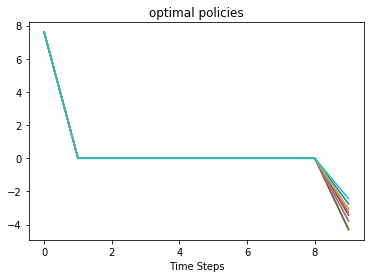

In [186]:
prices_paths = np.array(list_prices)
forecast_paths = np.array(list_forecast)

print(pd.Series(arg_dict))

plt.plot(prices_paths.T)
plt.xlabel('Time Steps')
plt.title('ID Price  Paths')
plt.show()

plt.plot(forecast_paths.T)
plt.xlabel('Time Steps')
plt.title('Fcst error  Paths')
plt.show()

df_scen = pd.DataFrame([], index = range(10), columns = list_values[0].columns)
for c in df_scen.columns:
    df_scen[c] = np.mean(np.array([df[c].values for df in list_values]), axis = 0)
df_scen = df_scen.append(df_scen.sum(axis=0), ignore_index=True)
print(df_scen)

plt.plot(np.array([k['model_trades'] for k in list_values]).T)
plt.xlabel('Time Steps')
plt.title('optimal policies')
plt.show()

#### case of low volatility and growth in price starting with 4MW short position

processing scenario....0


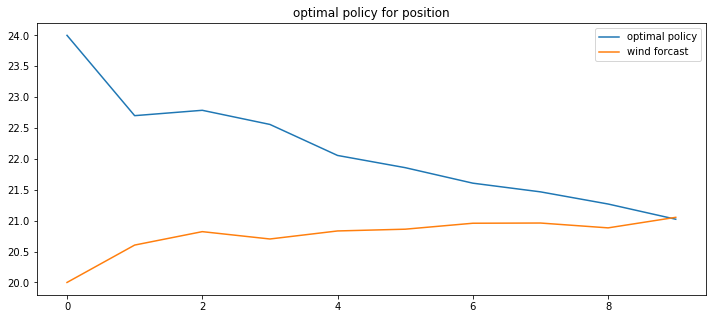

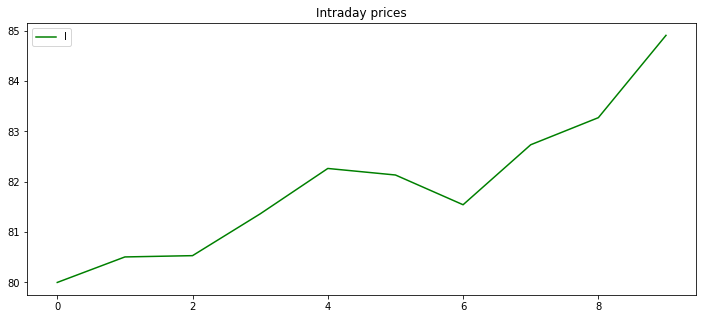

processing scenario....1


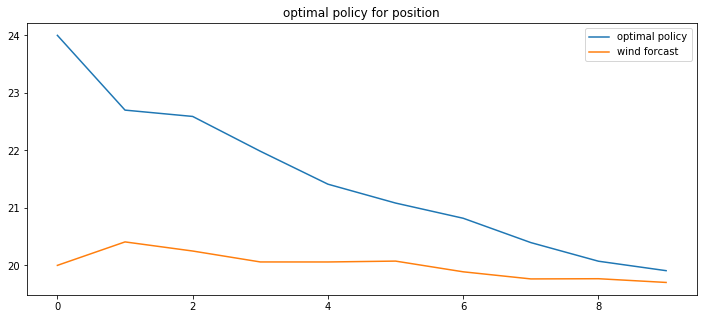

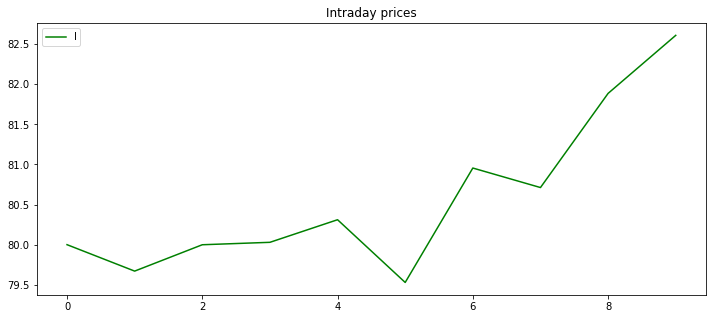

processing scenario....2


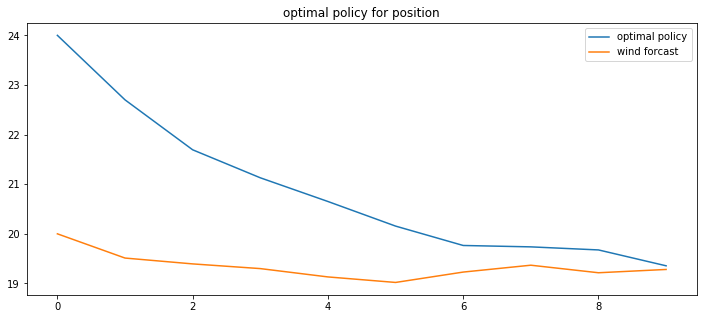

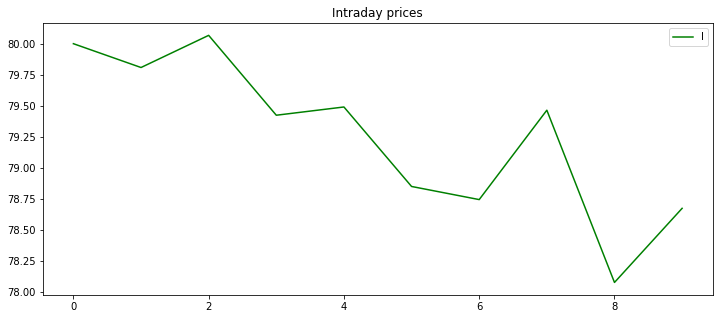

processing scenario....3


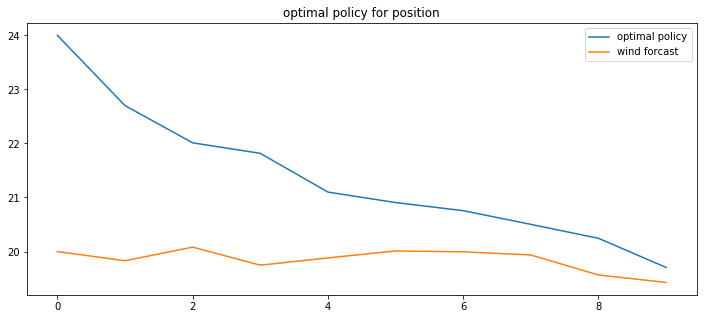

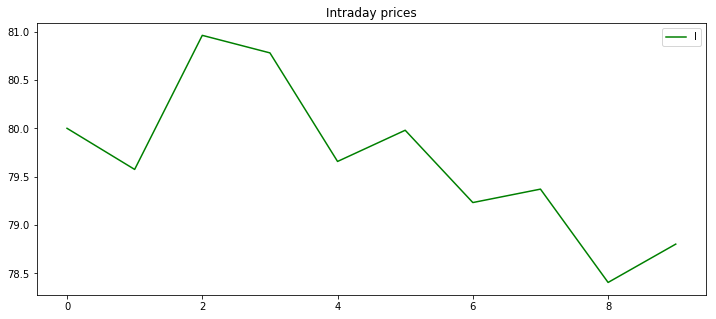

processing scenario....4


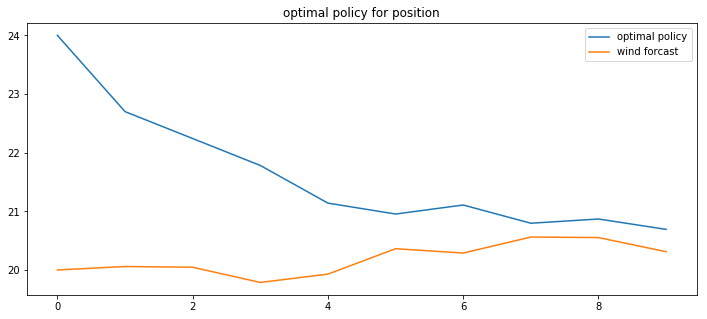

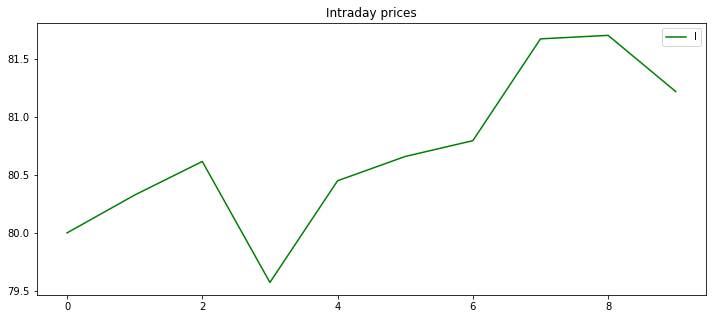

processing scenario....5


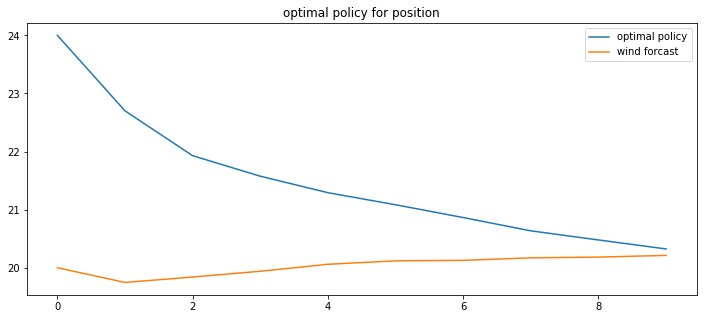

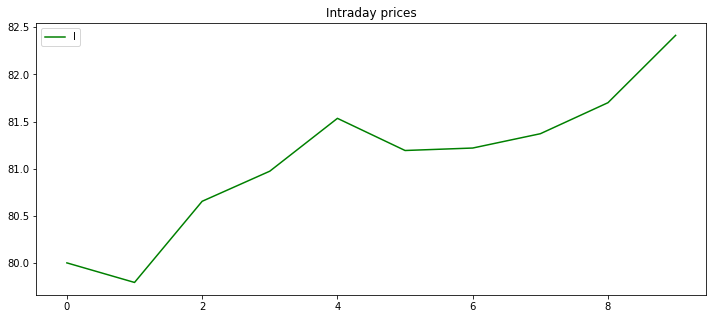

processing scenario....6


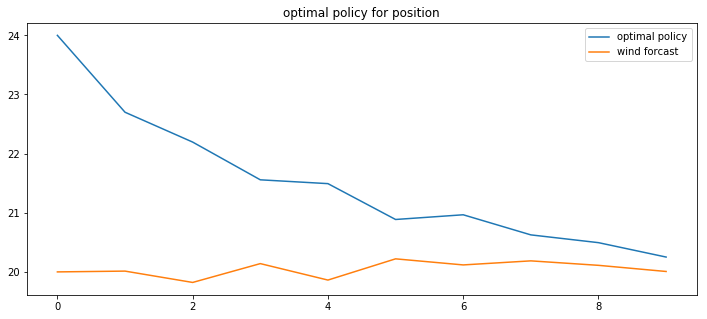

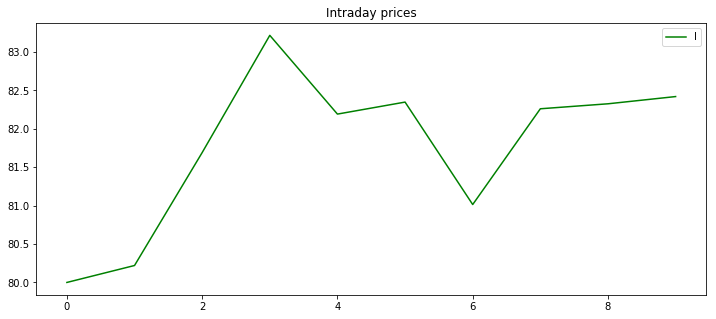

processing scenario....7


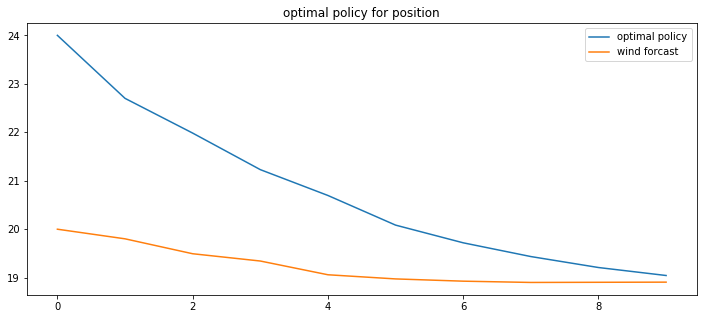

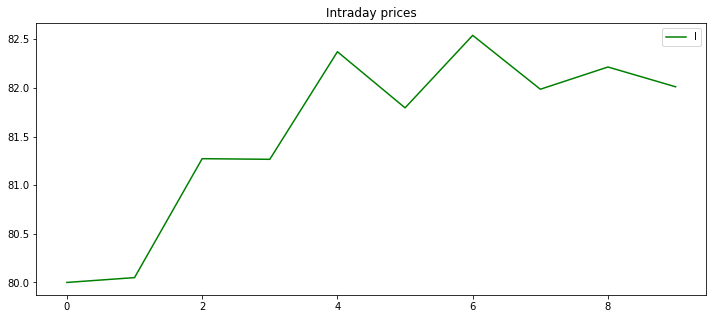

processing scenario....8


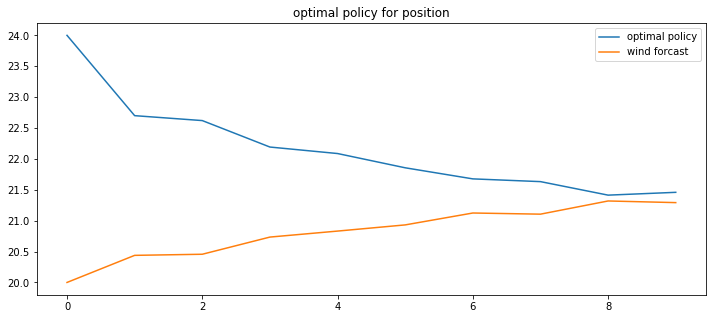

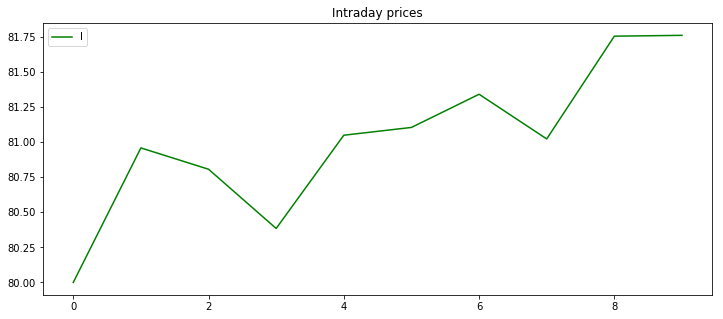

processing scenario....9


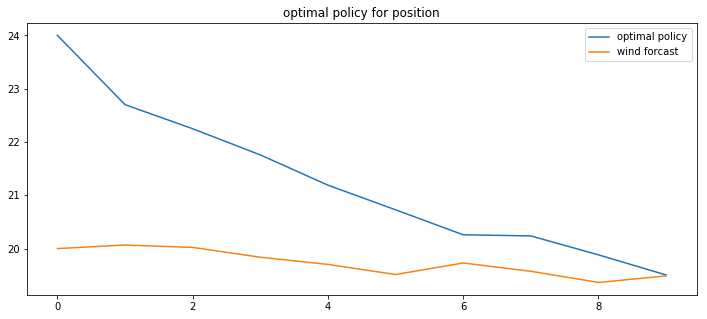

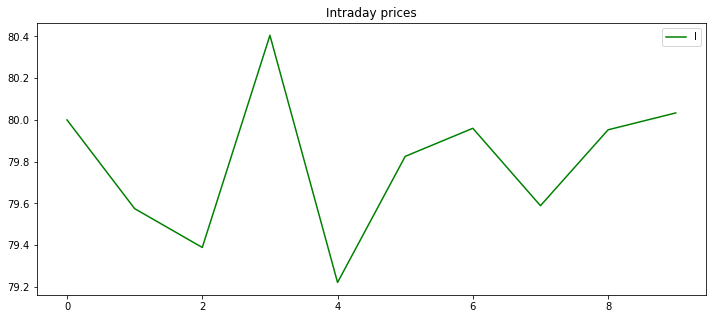

In [183]:
#case of low volatility and growth in price starting with 4MW short position
N_MC = 10

list_values = []
list_prices = []
list_forecast = []

for n in range(N_MC):
    print("processing scenario...." + str(n))
    result, P, F, arg_dict, final_pos = bidding_model(init_position = 24, #short init position of 10MW
                                      init_IDprice = 80,
                                      init_forecast = 20,
                                      rho = 0.3, #corrrelation btween the two process
                                      nb_trading_window = 10,
                                      delta_t = 1,
                                      sigma_p = 0.008,
                                      mu_p = 0.00005,
                                      sigma_f = 0.3,
                                      TC = 0.1,
                                      c_ime = 1.7, #imbalance market surcharge vs market trade
                                      c_imo = 1, #imbalance market 
                                      tau_c = 0.3,# discount rate (dynamically adjusted)
                                      phi_e = 0.3,#counterparty risk market trade at terminal step
                                      phi_o = 0,#counterparty risk counter trade at terminal step
                                      delta_c_s = 0.25, #bid ask spread at terminal step, dynamically adjusted 
                                      optim_method = 'scipy-minbd',
                                      price_dynamic = 'GBM',
                                      verbose = False #wether to show intermediate values
                     )
    ax = result['model_position'].plot(title = 'optimal policy for position', figsize= (12,5))
    result['forecast_dev'].plot(ax=ax)
    plt.legend(('optimal policy', 'wind forcast'))
    plt.show()
    result['ID_price'].plot(title = 'Intraday prices', figsize= (12,5), color = 'green')
    plt.legend(('ID price'))
    plt.show()
    list_values.append(result)
    list_prices.append(P)
    list_forecast.append(F)

init_position        24.000000
init_IDprice         80.000000
init_err_forecast    20.000000
corr_F_P              0.300000
nb_trading_window    10.000000
delta_t               1.000000
sigma_p               0.008000
mu_p                  0.000050
sigma_f               0.127229
TC                    0.100000
c_ime                 1.700000
c_imo                 1.000000
tau_c                 0.300000
phi_e                 0.300000
phi_o                 0.000000
delta_c_s             0.250000
dtype: float64


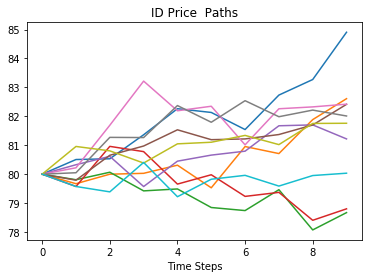

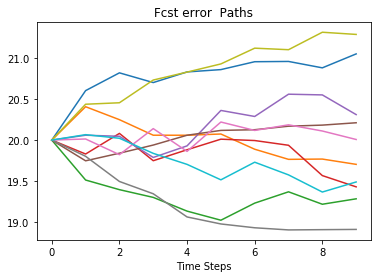

      ID_price  forecast_dev  model_trades  model_value  model_position  \
0    80.000000     20.000000      1.300005    -0.067281       24.000000   
1    80.048115     20.047986      0.470197    -0.068656       22.699995   
2    80.598631     20.022724      0.471541    -0.158945       22.229798   
3    80.741192     19.959210      0.446687    -0.316263       21.758257   
4    80.853615     19.935040      0.352015    -0.509608       21.311570   
5    80.741305     20.008858      0.205597    -0.650248       20.959556   
6    80.734026     20.038486      0.207452    -1.183121       20.753959   
7    81.018124     20.052883      0.185735    -2.084955       20.546507   
8    81.128653     19.986734      0.234090    -4.857084       20.360772   
9    81.484596     19.968522      0.158161    -5.305793       20.126683   
10  807.348258    200.020444      4.031478   -15.201953      214.747096   

    always_trades  always_trades_value  start_end_trade  \
0        4.000000            -0.027033  

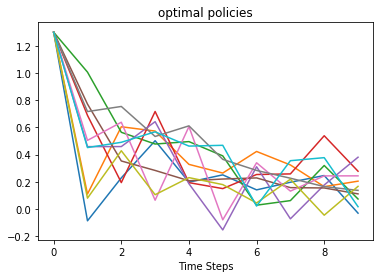

In [184]:
# results for sigmaP = 0.02, TC= 0.1, sigmaF=0.4, muP=0.005, rho=0.3, init pos = 0, P0=60, F0=20
prices_paths = np.array(list_prices)
forecast_paths = np.array(list_forecast)

print(pd.Series(arg_dict))

plt.plot(prices_paths.T)
plt.xlabel('Time Steps')
plt.title('ID Price  Paths')
plt.show()

plt.plot(forecast_paths.T)
plt.xlabel('Time Steps')
plt.title('Fcst error  Paths')
plt.show()

df_scen = pd.DataFrame([], index = range(10), columns = list_values[0].columns)
for c in df_scen.columns:
    df_scen[c] = np.mean(np.array([df[c].values for df in list_values]), axis = 0)
df_scen = df_scen.append(df_scen.sum(axis=0), ignore_index=True)
print(df_scen)

plt.plot(np.array([k['model_trades'] for k in list_values]).T)
plt.xlabel('Time Steps')
plt.title('optimal policies')
plt.show()

#### Case of mid volatility and price growth starting with 4MW short position

processing scenario....0


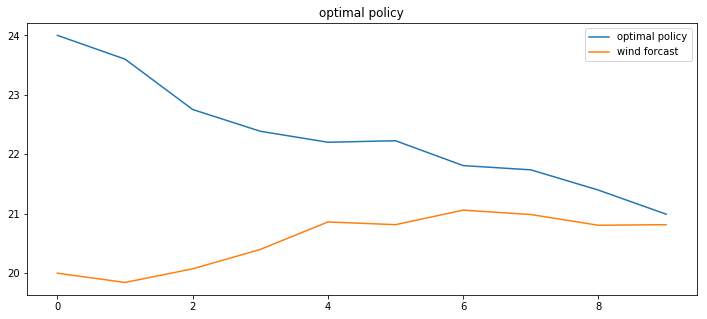

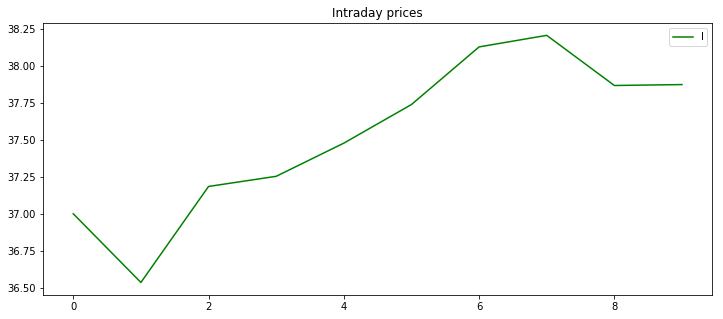

processing scenario....1


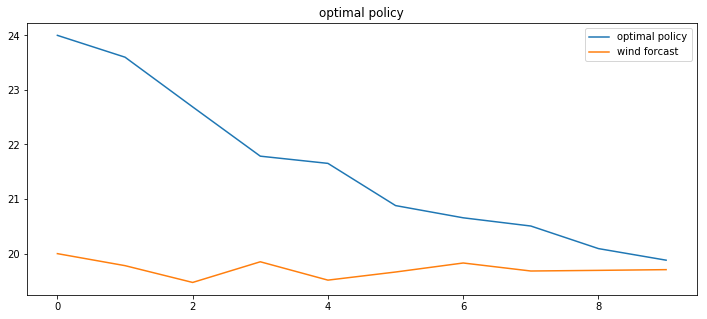

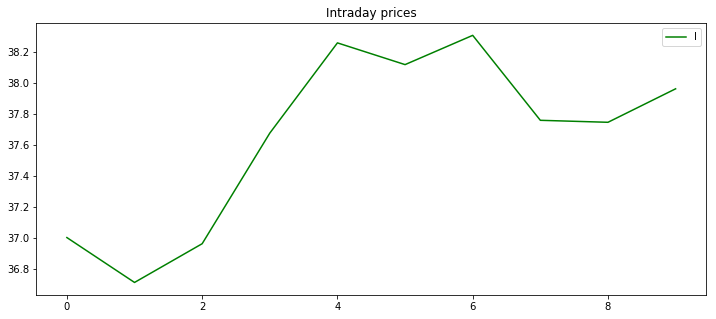

processing scenario....2


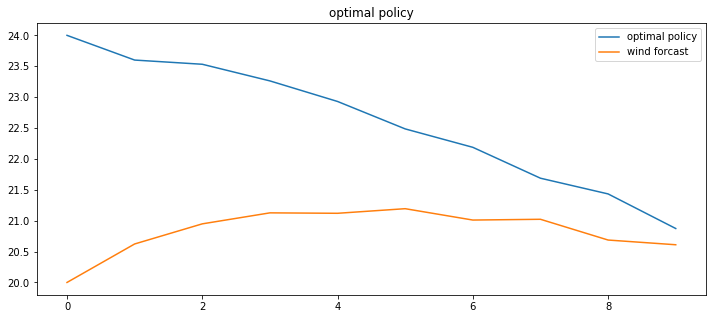

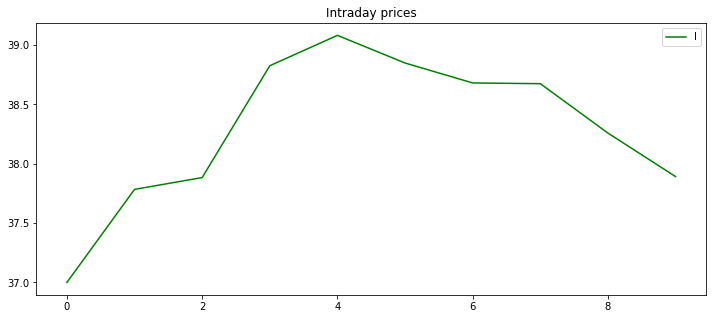

processing scenario....3


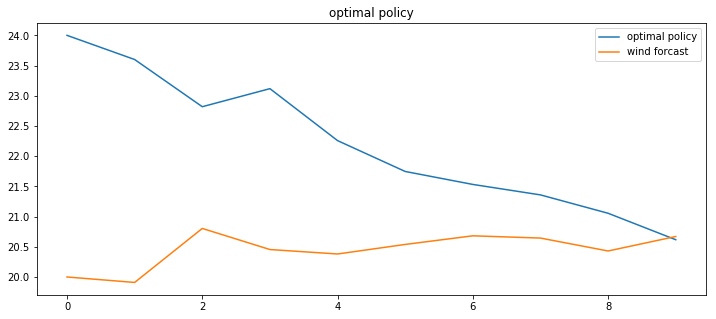

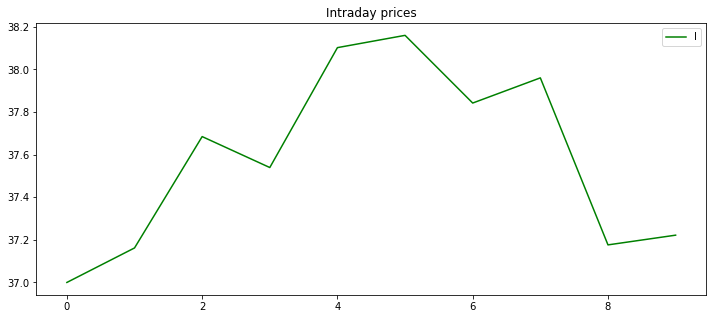

processing scenario....4


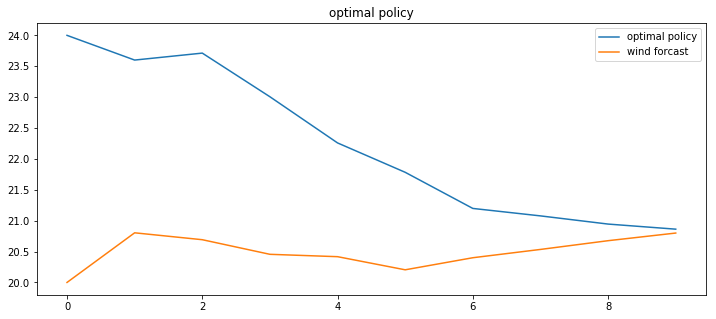

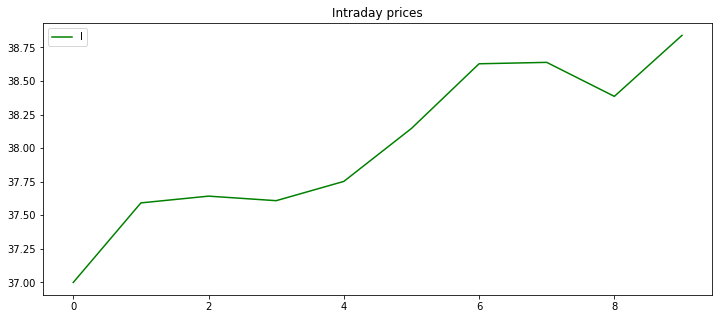

processing scenario....5


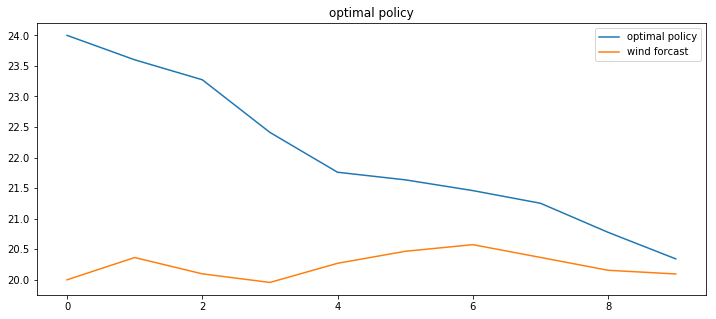

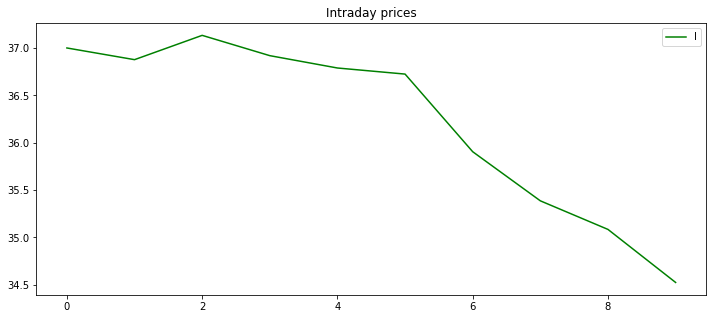

processing scenario....6


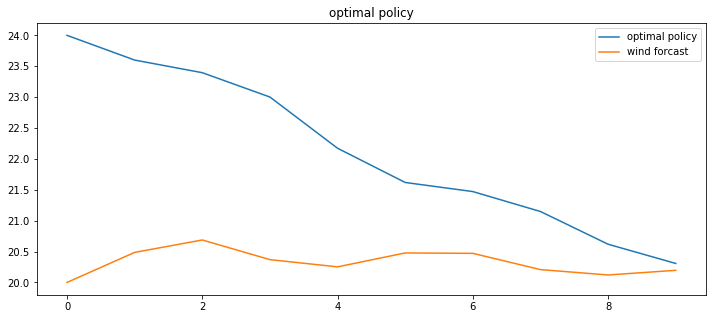

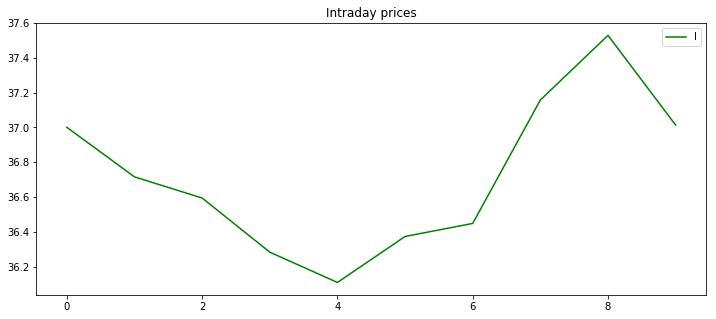

processing scenario....7


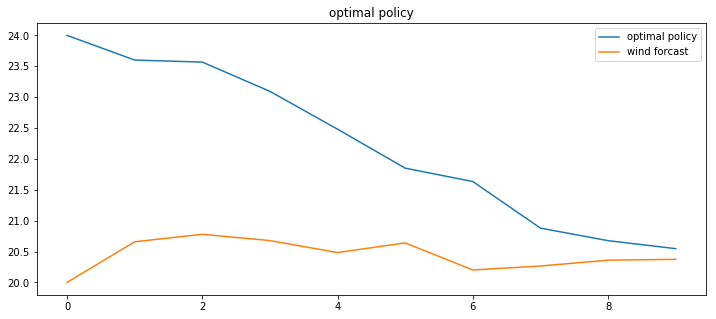

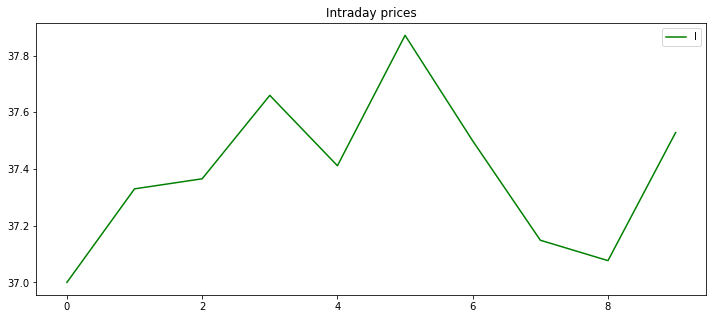

processing scenario....8


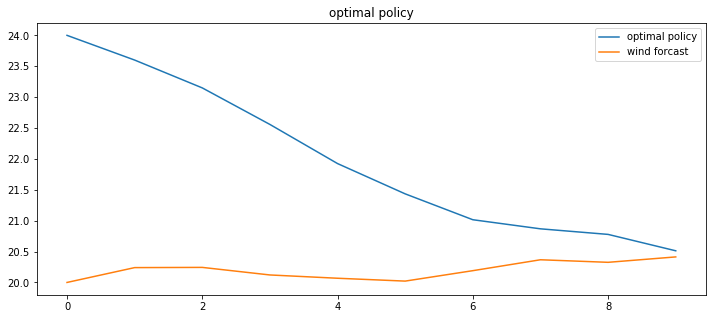

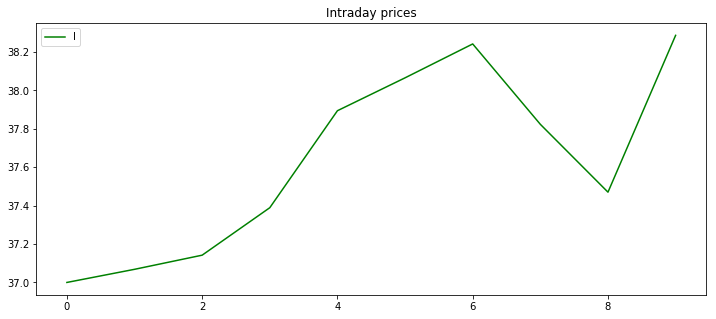

processing scenario....9


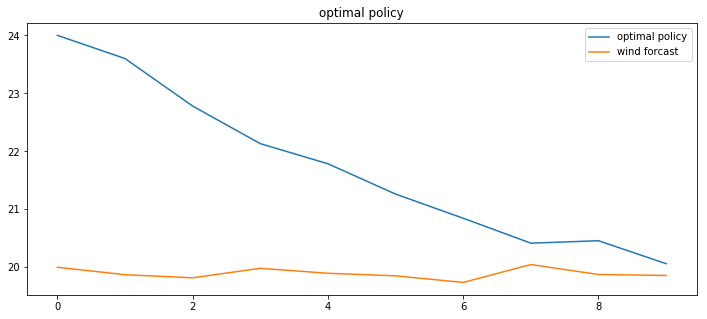

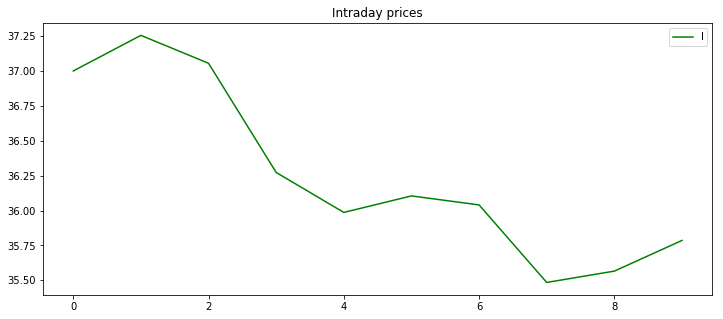

In [187]:
N_MC = 10

list_values = []
list_prices = []
list_forecast = []

for n in range(N_MC):
    print("processing scenario...." + str(n))
    result, P, F, arg_dict, final_pos = bidding_model(init_position = 24, #short init position of 10MW
                                      init_IDprice = 37,
                                      init_forecast = 20,
                                      rho = 0.3, #corrrelation btween the two process
                                      nb_trading_window = 10,
                                      delta_t = 1,
                                      sigma_p = 0.01,
                                      mu_p = 0.0001,
                                      sigma_f = 0.4,
                                      TC = 0.1,
                                      c_ime = 1.7, #imbalance market surcharge vs market trade
                                      c_imo = 1, #imbalance market 
                                      tau_c = 0.3,# discount rate (dynamically adjusted)
                                      phi_e = 0.3,#counterparty risk market trade at terminal step
                                      phi_o = 0,#counterparty risk counter trade at terminal step
                                      delta_c_s = 0.25, #bid ask spread at terminal step, dynamically adjusted 
                                      optim_method = 'scipy-minbd',
                                      price_dynamic = 'GBM',
                                      verbose = False #wether to show intermediate values
                     )
    ax = result['model_position'].plot(title = 'optimal policy', figsize= (12,5))
    result['forecast_dev'].plot(ax=ax)
    plt.legend(('optimal policy', 'wind forcast'))
    plt.show()
    result['ID_price'].plot(title = 'Intraday prices', figsize= (12,5), color = 'green')
    plt.legend(('ID price'))
    plt.show()
    list_values.append(result)
    list_prices.append(P)
    list_forecast.append(F)

init_position        24.000000
init_IDprice         37.000000
init_err_forecast    20.000000
corr_F_P              0.300000
nb_trading_window    10.000000
delta_t               1.000000
sigma_p               0.010000
mu_p                  0.000100
sigma_f               0.169639
TC                    0.100000
c_ime                 1.700000
c_imo                 1.000000
tau_c                 0.300000
phi_e                 0.300000
phi_o                 0.000000
delta_c_s             0.250000
dtype: float64


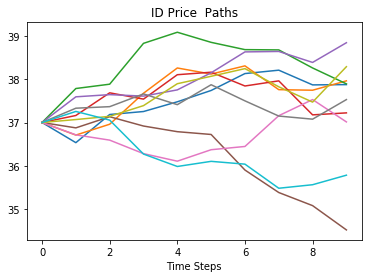

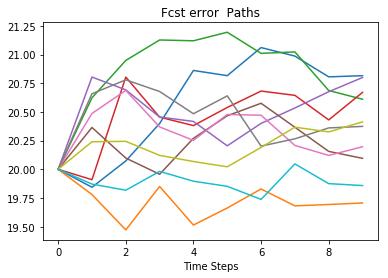

      ID_price  forecast_dev  model_trades  model_value  model_position  \
0    37.000000     20.000000      0.400006    -0.001806       24.000000   
1    37.102869     20.257990      0.432918    -0.019449       23.599994   
2    37.264451     20.361547      0.491486    -0.064558       23.167076   
3    37.342346     20.339295      0.533144    -0.163263       22.675590   
4    37.485846     20.326374      0.450050    -0.291181       22.142446   
5    37.614737     20.387387      0.311538    -0.404423       21.692395   
6    37.571701     20.415734      0.287759    -0.734775       21.380857   
7    37.423517     20.412340      0.270236    -1.349230       21.093098   
8    37.215604     20.313008      0.323257    -2.975239       20.822862   
9    37.292470     20.353998      0.145607    -1.769107       20.499605   
10  373.313541    203.167672      3.646002    -7.773031      221.073922   

    always_trades  always_trades_value  start_end_trade  \
0        4.000000             0.005142  

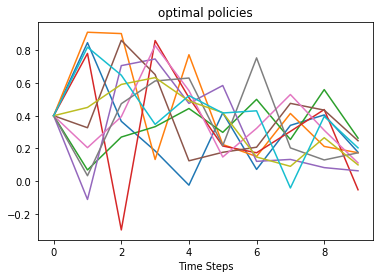

In [188]:
prices_paths = np.array(list_prices)
forecast_paths = np.array(list_forecast)

print(pd.Series(arg_dict))

plt.plot(prices_paths.T)
plt.xlabel('Time Steps')
plt.title('ID Price  Paths')
plt.show()

plt.plot(forecast_paths.T)
plt.xlabel('Time Steps')
plt.title('Fcst error  Paths')
plt.show()

df_scen = pd.DataFrame([], index = range(10), columns = list_values[0].columns)
for c in df_scen.columns:
    df_scen[c] = np.mean(np.array([df[c].values for df in list_values]), axis = 0)
df_scen = df_scen.append(df_scen.sum(axis=0), ignore_index=True)
print(df_scen)

plt.plot(np.array([k['model_trades'] for k in list_values]).T)
plt.xlabel('Time Steps')
plt.title('optimal policies')
plt.show()

### Other tests

init_position        30.000000
init_IDprice         37.000000
init_err_forecast    20.000000
corr_F_P              0.300000
nb_trading_window    10.000000
delta_t               1.000000
sigma_p               0.040000
mu_p                  0.005000
sigma_f               0.254459
TC                    0.100000
c_ime                 1.700000
c_imo                 1.000000
tau_c                 0.300000
phi_e                 0.300000
phi_o                 0.000000
delta_c_s             0.250000
dtype: float64


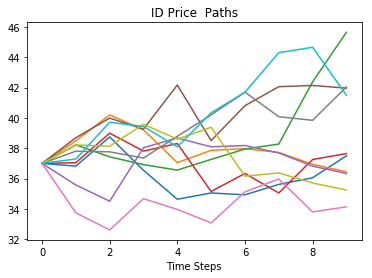

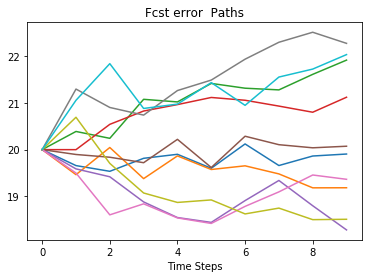

      ID_price  forecast_dev  model_trades  model_value  always_trades  \
0    37.000000     20.000000      6.400001     0.052348      10.000000   
1    37.187630     20.153457     -0.529750     0.106105      -0.153457   
2    37.807214     20.067064      0.762216    -0.089089       0.086393   
3    37.880950     19.923148      0.739657    -0.227751       0.143917   
4    37.683275     20.016367      0.562475    -0.353943      -0.093220   
5    37.489594     20.003528      0.571666    -0.732445       0.012839   
6    38.082480     20.163103      0.314583    -0.882250      -0.159575   
7    38.312286     20.248512      0.314855    -1.655417      -0.085409   
8    38.558686     20.248379      0.336020    -3.156143       0.000133   
9    38.844296     20.265740      0.262538    -3.862455      -0.017361   
10  378.846410    201.089300      9.734260   -10.801041       9.734260   

    always_trades_value  start_end_trade  start_end_trade_value  end_trades  \
0              0.038673         

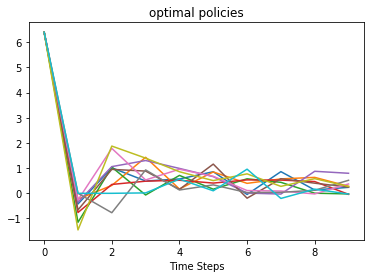

In [156]:
prices_paths = np.array(list_prices)
forecast_paths = np.array(list_forecast)

print(pd.Series(arg_dict))

plt.plot(prices_paths.T)
plt.xlabel('Time Steps')
plt.title('ID Price  Paths')
plt.show()

plt.plot(forecast_paths.T)
plt.xlabel('Time Steps')
plt.title('Fcst error  Paths')
plt.show()

df_scen = pd.DataFrame([], index = range(10), columns = list_values[0].columns)
for c in df_scen.columns:
    df_scen[c] = np.mean(np.array([df[c].values for df in list_values]), axis = 0)
df_scen = df_scen.append(df_scen.sum(axis=0), ignore_index=True)
print(df_scen)

plt.plot(np.array([k['model_trades'] for k in list_values]).T)
plt.xlabel('Time Steps')
plt.title('optimal policies')
plt.show()

init_position        30.000000
init_IDprice         37.000000
init_err_forecast    20.000000
corr_F_P              0.300000
nb_trading_window    10.000000
delta_t               1.000000
sigma_p               0.040000
mu_p                  0.005000
sigma_f               0.254459
TC                    0.500000
c_ime                 1.700000
c_imo                 1.000000
tau_c                 0.300000
phi_e                 0.300000
phi_o                 0.000000
delta_c_s             0.250000
dtype: float64


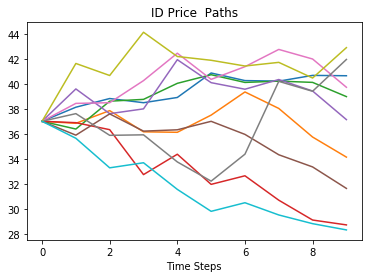

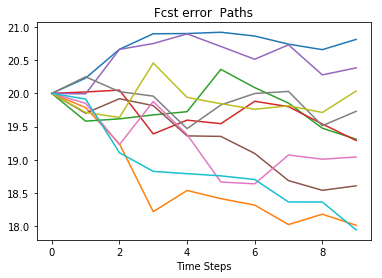

      ID_price  forecast_dev  model_trades  model_value  always_trades  \
0    37.000000     20.000000      5.200000     0.043733      10.000000   
1    37.703009     19.903939      0.532430    -0.021010       0.096061   
2    37.512290     19.814946      0.981555    -0.124845       0.088993   
3    37.431902     19.786584      0.794702    -0.223970       0.028361   
4    37.760944     19.659386      0.782893    -0.510780       0.127199   
5    37.237168     19.639041      0.579172    -0.763623       0.020345   
6    37.551847     19.585635      0.527565    -1.391745       0.053406   
7    37.797321     19.511067      0.474831    -2.326716       0.074568   
8    36.905664     19.326442      0.520512    -4.902019       0.184626   
9    36.409851     19.316461      0.289880    -3.727008       0.009981   
10  373.309995    196.543501     10.683539   -13.947982      10.683539   

    always_trades_value  start_end_trade  start_end_trade_value  end_trades  \
0             -1.339452        1

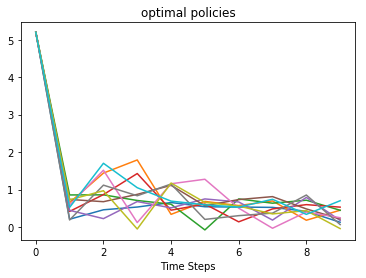

In [158]:
prices_paths = np.array(list_prices)
forecast_paths = np.array(list_forecast)

print(pd.Series(arg_dict))

plt.plot(prices_paths.T)
plt.xlabel('Time Steps')
plt.title('ID Price  Paths')
plt.show()

plt.plot(forecast_paths.T)
plt.xlabel('Time Steps')
plt.title('Fcst error  Paths')
plt.show()

df_scen = pd.DataFrame([], index = range(10), columns = list_values[0].columns)
for c in df_scen.columns:
    df_scen[c] = np.mean(np.array([df[c].values for df in list_values]), axis = 0)
df_scen = df_scen.append(df_scen.sum(axis=0), ignore_index=True)
print(df_scen)

plt.plot(np.array([k['model_trades'] for k in list_values]).T)
plt.xlabel('Time Steps')
plt.title('optimal policies')
plt.show()

### Backtesting part

#### Procedure :
- Make a sample of historical date and hourly products that reflect the range of possible market situation (volatility, forecast deviation)
- Extract the ID price and reforcast wind production historical pathes
- Run the bidding model replacing Monte Carlo pathes by the true realized values
- Comparing with both alternative simple strategy and historical trades with some benchmark of new value functions, to be discuss...


### Using least-square MC

#### Default parameters

In [3]:
## set up parameters for base model
phi_e = 0.3 #counterparty risk market trade
phi_o = 0 #counterparty risk counter trade
c_ime = 1.7 #imbalance market surcharge vs market trade
c_imo = 1 #imbalance market 
c_s = 0.05 #bid-ask spread
delta_c_s = 0.25 #spread growth of bid-ask spread
TC = 0.1 #transaction costs
tau_c = 0.3 
P0 = 60
F0 = 20 
corr = 0.3
N_MC = 100
T = 10
delta_t = 1
mu_p = 0.002
sigma_p = 0.02
sigma_f = 0.4
r = 0 #0.03 
grid_size = 100
mi = 0 #permanent market impact of trade factor
day_ahead_pos = 20

In [4]:
def cost_b( P, delta_P, sign_F, c_ime, phi_e, delta_c_s):
    cb = (1 - phi_e)*(delta_P + 0.5*sign_F*delta_c_s) + phi_e*(c_ime - P)
    #cb = delta_P
    return cb

#cost of double trade
def cost_d( P, delta_P, sign_F, c_imo, TC, phi_o, delta_c_s):
    cd = sign_F*(TC + c_s/2) + (1 - phi_o)*(- delta_P + sign_F*(TC + (delta_c_s + c_s)/2)) + phi_o*( - c_imo  + P)
    #cd = - delta_P
    return cd

def v_trade( F, P, q, delta_P, sign_F, c_ime, phi_e, c_imo, TC, phi_o, delta_c_s):
    #sum_cd = - cost_d( P, delta_P, sign_F, c_imo, TC, phi_o)*max([0,(q-F)])
    unit_cost_c = cost_d( P, delta_P, sign_F, c_imo, TC, phi_o, delta_c_s)
    unit_cost_b = cost_b( P, delta_P, sign_F,c_ime, phi_e, delta_c_s)
    #tot_cost = unit_cost_b*min(F,q) - unit_cost_c*unit_cost_b*(max([0,(q-F)]))**2
    tot_cost = np.multiply((unit_cost_b*np.multiply(np.minimum(F,q),(q>0))- np.multiply((q>F),(q-F))*unit_cost_c - np.multiply(q,(q<=0))*unit_cost_c),(F>0)) \
                + np.multiply((unit_cost_b*np.multiply(np.maximum(F,q),(q<0)) - np.multiply((q<F),(q-F))*unit_cost_c - np.multiply(q,(q>0))*unit_cost_c),(F<=0))
    
    return tot_cost

def terminal_value(F,P, q, T, phi_e, c_ime):
    tv = (1-phi_e)*(q-F[:,T-1])*(c_ime - P[:,T-1])
    return tv

def terminal_position(F, T):
    return F[:,T-1]

def terminal_position(F, T):
    return F[:,T-1]

In [44]:
def MC_forward_path(N_MC, T, delta_t, mu_p, sigma_p, sigma_f, P0, F0, corr, day_ahead_pos):
    
    """
    function MC_path_2D - Generate two MC pathes according to the precedent formulas
    
    Arguments:
    N_MC - number of trajectories
    delta_t - size of time step
    mu_p - ID price growth
    sigma_p - ID price volatility
    sigma_f - fct err volatility
    P0 - initial price
    F0 - initial fct err
    corr - correlation btween price and forecast
    Return:
    - two 2D-arrays of size N_MC x T

    """
    np.random.seed(42)
    
    # ID price
    P = np.zeros((N_MC,T))
    P[:,0] = P0
    #Forecast
    F = np.zeros((N_MC,T))
    F[:,0] = F0    

    # standard normal random numbers
    W_P = np.random.randn(N_MC,T)
    W_F = np.random.randn(N_MC,T)
    
    for t in range(1,T):
        P[:,t] = P[:,t-1] * np.exp((mu_p - 1/2 * sigma_p**2) * delta_t + sigma_p * np.sqrt(delta_t) * W_P[:,t])
        F[:,t] = F[:,t-1] + sigma_f*np.sqrt(delta_t)*(corr*W_P[:,t] + np.sqrt(1-corr**2)*W_F[:,t])
                
    delta_F = np.zeros((N_MC,T))
    delta_P = np.zeros((N_MC,T))
    
    delta_F[:,1:] = F[:,1:T] - F[:,0:T-1]
    
    # discounted P variation
    delta_P[:,1:] = P[:,1:T] - np.exp(r * delta_t) * P[:,0:T-1]

    
    #sample of random positions
    q = np.zeros((N_MC,T))
    q[:,0] = 0
    for t in range(1,T):
        q[:,t] = np.random.uniform(np.min(F[:,T-1]), np.max(F[:,T-1]), N_MC)

    #compute corresponding hedging  trades 
    delta_q = np.zeros((N_MC,T))
    for t in range(1,T):
        delta_q[:,t] = q[:,t] - q[:,t-1]

    sign_F = np.divide((F-q), np.absolute((F-q)), out=np.ones_like(F), where=((F-q)!=0))

    #compute corresponding position values
    V_trade = np.zeros((N_MC, T))
    for n in range(N_MC):
        for t in range(1,T):
            
            V_trade[n,t] = v_trade( q[n,t-1] - F[n,t], P[n,t], delta_q[n,t], delta_P[n,t], sign_F[n,t], c_ime, phi_e, c_imo, TC, phi_o, delta_c_s)
            #F[n,T-1]
    V_tot = np.cumsum(V_trade)  
    
    
    return P, F, delta_F, delta_P, sign_F, q, delta_q, V_trade, V_tot

In [6]:
def basis_function(R1, R2, X,Y, basis = 'laguerre' ): #monomial
    
    """
    basis_function_laguerre - Create Laguerre polynomial for basis of two asset path
    
    Arguments:
    X - numpy array of values to express in basis function
    Y - numpy array of values to express in basis function
    R1 - order  for X
    R2 - order  for Y
    Return:
    - the R1,R2 order 2D Laguerre polynomial evaluate in x and y

    """
    if R1==0:
        return 0.*X
    if R2==0:
        return 0.*X
    
    else:
        if basis == 'laguerre':
            coef = np.zeros((R1,R2))
            coef[-1,-1] = 1
            #fit least square projection coefficients for X and Y
            #coef_X = np.polynomial.laguerre.lagfit(x, X, R1, rcond=None, full=False, w=None)
            #coef_Y = np.polynomial.laguerre.lagfit(y, Y, R2, rcond=None, full=False, w=None)
            value = np.polynomial.laguerre.lagval2d(X,Y,coef)
            return value
        
        if basis == 'monomial':
            return np.multiply(np.power(X,R1), np.power(Y,R2))
        
 

In [10]:
# functions for least square regession
def function_A_vec(t, P, F, R, reg_param = 0.0001):
    
    B_psi_psi = np.zeros((R**2, R**2))
    
    for i in range(R):
        for j in range(R):
            for k in range(R):
                for l in range(R):

                    psi_1 = basis_function(i,j,P[:,t],F[:,t])
                    psi_2 = basis_function(k,l,P[:,t],F[:,t])

                    B_psi_psi[(i)*(j),(k)*(l)] = sum(np.multiply(psi_1, psi_2))
                    B_psi_psi[(i)*(j),(k)*(l)] = B_psi_psi[(i)*(j),(k)*(l)]/N_MC
                    
    B_psi_psi = B_psi_psi + reg_param*np.eye(R**2)

    return B_psi_psi
   
        
def function_B_vec(t, R, P, F, V):
    
    B_V_psi = np.zeros((R**2))

    for i in range(R): #put the value V
        for j in range(R):

            B_V_psi[(i)*(j)]=sum(np.multiply(V, basis_function(i+1,j+1,P[:,t],F[:,t])))
            B_V_psi[(i)*(j)]=B_V_psi[(i)*(j)]/N_MC
            
    return B_V_psi


def continuationVal(t,a,R,P,F,Beta,N_MC):

    ContinuationVal=np.zeros(N_MC)
    for i in range(R):
        for j in range(R):
            ContinuationVal = ContinuationVal + basis_function(i,j,P[:,t],F[:,t])*Beta[(i)*(j),a,t]
            
    return ContinuationVal

In [39]:
def LS_regression(day_ahead_pos, #initial position
                   N_MC, #nb path
                   nb_step, #delivery time
                   grid_size,
                   T, #delivery
                   R, #num basis
                   mu_p,
                   sigma_p,
                   sigma_f,
                   P0,
                   F0,
                   corr,
                   phi_e,
                   c_ime,
                   basis = 'laguerre' ):
    
    random.seed(20)
    delta_t = T/nb_step
    #step1: generate MC paths
    print("begin forward path generation......")
    P, F, delta_F, delta_P, sign_F, q, delta_q, V_trade, V_tot = MC_forward_path(N_MC, nb_step, delta_t, mu_p, sigma_p, sigma_f, P0, F0, corr ,day_ahead_pos)

    #discretization of control space
    Q = np.linspace(np.min(F[:,T-1]), np.max(F[:,T-1]), grid_size)

    q[:,T-1] = terminal_position(F, T)
    
    Beta = np.zeros((R**2, grid_size, nb_step))

    continuation_val = np.zeros((N_MC, grid_size, T))
    V_temp = np.zeros((N_MC, grid_size, T))
    q_temp = np.zeros((N_MC, grid_size, T))
    delta_q_temp = np.zeros((N_MC, grid_size, T))
    
    V_star = np.zeros((N_MC, T))
    q_star = np.zeros((N_MC, T))
    delta_q_star = np.zeros((N_MC, T))


    
    #backward recursion
    for t in range(nb_step-2,-1,-1):
        
        print("processing time ............", t)
        
        
        for a in range(Q.shape[0]):

            V_star_a = np.zeros((N_MC, T))
            q_star_a = np.zeros((N_MC, T))
            delta_q_star_a= np.zeros((N_MC, T))
            
            
            if t==T-2:
                
                V_temp[:,a,t+1] = terminal_value(F,P, q[:,t]-Q[a]*np.ones(N_MC), T, phi_e, c_ime)
                V_star[:,t+1] = terminal_value(F,P, q[:,t]-q[:,t+1], T, phi_e, c_ime)
                q_star[:,t+1] = q[:,t+1]
                A_mat = function_A_vec(t, P, F, R)
                B_vec = function_B_vec(t, R, P, F, V_star[:,t+1])
                Beta[:,a,t] = np.dot(np.linalg.inv(A_mat), B_vec)

                continuation_val[:,a,t] = continuationVal(t,a,R,P,F,Beta, N_MC)

            else:
                
                V_temp[:,a,t+1] = V_trade[:,t] +  v_trade(q[:,t] - F[:,t+1], P[:,t+1],  Q[a]*np.ones(N_MC), delta_P[:,t+1], sign_F[:,t+1], c_ime, phi_e, c_imo, TC, phi_o, delta_c_s) #+ V_tot[n,t] 
                #V_temp[:,a,t+1] = v_trade(q[:,t] - F[:,t], P[:,t],  Q[a]*np.ones(N_MC), delta_P[:,t], sign_F[:,t], c_ime, phi_e, c_imo, TC, phi_o, delta_c_s) #+ V_tot[n,t] 
                q_star_a[:,t+1] = q[:,t] - Q[a]*np.ones(N_MC)
                V_star_a[:,t+1] = V_temp[:,a,t+1] 
                
                for t1 in range(t+1,T-1):
 
                    for n in range(N_MC):
                        #V_star_a[n,t1+1] = V_star_a[n,t1] + np.max(continuation_val[n,:,t1])
                        #V_star_a[n,t1+1] = np.max(continuation_val[n,:,t1])
                        arg_max = np.argmax(continuation_val[n,:,t1]) 
                        delta_q_star_a[n,t1] = Q[arg_max]                      
                        q_star_a[n,t1+1] = q_star[n,t1] - delta_q_star[n,t1]
                        V_star_a[n,t1+1] = V_star_a[n,t1] + np.max(continuation_val[n,:,t1])

                A_mat = function_A_vec(t, P, F, R)
                B_vec = function_B_vec(t, R, P, F, V_star_a[:,T-1])
                Beta[:,a,t] = np.dot(np.linalg.inv(A_mat), B_vec)

                continuation_val[:,a,t] = continuationVal(t,a,R,P,F,Beta, N_MC)
    
        if t<T-2:
            for n in range(N_MC):
                V_star[n,t+1] = V_trade[n,t] + np.max(continuation_val[n,:,t])
                #V_star[n,t+1] = np.max(continuation_val[n,:,t])
                arg_max = np.argmax(continuation_val[n,:,t]) 
                delta_q_star[n,t+1] = Q[arg_max]                      
                q_star[n,t+1] = q[n,t] - delta_q_star[n,t+1]
        
    
    return V_star, q_star, delta_q_star, P, F


In [45]:
V_star, q_star, delta_q_star, P, F = LS_regression(day_ahead_pos=30, #initial position
                                                   N_MC=100, #nb path
                                                   nb_step=10, #delivery time
                                                   grid_size = 100,
                                                   T=10, #delivery
                                                   R=6, #num basis
                                                   mu_p=0.002,
                                                   sigma_p=0.05,
                                                   sigma_f=0.4,
                                                   P0=60,
                                                   F0=20,
                                                   corr=0.3,
                                                   phi_e=0.3,
                                                   c_ime= 1.7,
                                                   basis = 'laguerre' )

begin forward path generation......
processing time ............ 8
processing time ............ 7
processing time ............ 6
processing time ............ 5
processing time ............ 4
processing time ............ 3
processing time ............ 2
processing time ............ 1
processing time ............ 0
